In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [5]:
def load_complexity_scores():
    rsivl = "/ptmp/tshen/shared/RSIVL/labels.xls"
    visc = "/ptmp/tshen/shared/VISC/VISC-C/labels.csv"
    sav_obj = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_objects.xlsx"
    sav_sce = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_scenes.xlsx"
    sav_art = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_art.xlsx"
    sav_int = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_interior_design.xlsx"
    sav_sup = "/ptmp/tshen/shared/Savoias/labels/xlsx/global_ranking_sup.xlsx"
    ic9600 = ["/ptmp/tshen/shared/IC9600/train.txt", "/ptmp/tshen/shared/IC9600/test.txt"]

    labels = {}
    labels['rsivl'] = pd.read_excel(rsivl)
    labels['rsivl'].rename(columns={'subjective scores': 'complexity', 'Unnamed: 0': 'filename'}, inplace=True)
    labels['rsivl']['filename'] = labels['rsivl']['filename'] + ".bmp"
    labels['visc'] = pd.read_csv(visc)
    labels['visc'].rename(columns={'score': 'complexity', 'image': 'filename'}, inplace=True)

    for v, n in zip([sav_obj, sav_sce, sav_art, sav_int, sav_sup], ["sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup"]):
        labels[n] = pd.read_excel(v)
        labels[n].rename(columns={'gt': 'complexity'}, inplace=True)
        labels[n]['filename'] = ["{}.jpg".format(i) for i in range(len(labels[n]))]

    labels['ic9600'] = pd.concat([pd.read_csv(fn, names=["filename", "complexity"], header=None, delimiter=r"  ") for fn in ic9600])
    assert len(labels['ic9600']) == 9600

    for k in labels.keys():
        assert labels[k][['filename', 'complexity']].isnull().values.any() == False

    return labels

In [6]:
def load_predictions(folder="../out/2023July20", filenames=['4points', '8points', '16points', '32points', '64points']):
    rsivl = "{}/RSIVL".format(folder)
    visc = "{}/VISC".format(folder)
    sav_obj = "{}/Savoias-Objects".format(folder)
    sav_sce = "{}/Savoias-Scenes".format(folder)
    sav_art = "{}/Savoias-Art".format(folder)
    sav_int = "{}/Savoias-IntDesign".format(folder)
    sav_sup = "{}/Savoias-Suprematism".format(folder)
    ic9600 = "{}/IC9600".format(folder)

    preds = {}
    
    for v, n in zip([rsivl, visc, sav_obj, sav_sce, sav_art, sav_int, sav_sup, ic9600], ["rsivl", "visc", "sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup", "ic9600"]):
        preds_dataset = []
        single_file_len = 0

        for f in filenames:
            df = pd.read_csv("{}/{}.csv".format(v, f), names=["filename", f], header=None)
            preds_dataset.append(df)
            single_file_len = len(df)

        combined_df = pd.concat([df.set_index("filename") for df in preds_dataset], axis=1, join='inner').reset_index()  # join on filename
        assert len(combined_df) == single_file_len
        assert combined_df.isnull().values.any() == False

        preds[n] = combined_df

    preds['rsivl']['filename'] = preds['rsivl']['filename'].str.replace('.json', '.bmp', regex=False)
    for k in ["visc", "sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup", "ic9600"]:
        preds[k]['filename'] = preds[k]['filename'].str.replace('.json', '.jpg', regex=False)

    return preds

In [7]:
def join_preds_labels(preds, labels):
    data = {}
    
    for k in ["rsivl", "visc", "sav_obj", "sav_sce", "sav_art", "sav_int", "sav_sup", 'ic9600']:
        data[k] = pd.concat([preds[k].set_index("filename"), labels[k][['filename', 'complexity']].set_index("filename")], axis=1, join='inner').reset_index()
        if k != 'ic9600':
            assert len(data[k]) == len(preds[k]) == len(labels[k])
        else:
            print(len(data[k]), len(preds[k]), len(labels[k]))
            assert len(data[k]) < len(preds[k]) == len(labels[k])  # dataset just doesn't align
        assert data[k].isnull().values.any() == False

    return data

In [8]:
levels = ['4points', '8points', '16points', '32points', '64points']

In [9]:
preds = load_predictions(folder="../out/2023July20", filenames=levels)
labels = load_complexity_scores()
data = join_preds_labels(preds, labels)

9425 9600 9600


/tmp/ipykernel_57412/1990212771.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels['ic9600'] = pd.concat([pd.read_csv(fn, names=["filename", "complexity"], header=None, delimiter=r"  ") for fn in ic9600])
/tmp/ipykernel_57412/1990212771.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels['ic9600'] = pd.concat([pd.read_csv(fn, names=["filename", "complexity"], header=None, delimiter=r"  ") for fn in ic9600])


In [10]:
levels2 = ['64points0.88pred_iou_thresh', '64points0.92pred_iou_thresh', '64points0.95pred_iou_thresh', '64points0.97pred_iou_thresh', '64points0.99pred_iou_thresh']
preds2 = load_predictions(folder="../out/2023July21", filenames=levels2)
data2 = join_preds_labels(preds2, labels)

9425 9600 9600


# Correlations

In [21]:
def get_correlations(data, levels):
    correlations, spearmans, r2 = {}, {}, {}

    for dataset in data.keys():
        correlations[dataset] = {}
        spearmans[dataset] = {}
        r2[dataset] = {}
        columns = ['complexity'] + levels

        for i in range(len(columns)):
            correlations[dataset][columns[i]] = {}
            spearmans[dataset][columns[i]] = {}
            r2[dataset][columns[i]] = {}

            for j in range(i+1, len(columns)):
                x = data[dataset][columns[i]]
                y = data[dataset][columns[j]]

                correlations[dataset][columns[i]][columns[j]] = stats.pearsonr(x, y)
                spearmans[dataset][columns[i]][columns[j]] = stats.spearmanr(x, y)
                model = np.poly1d(np.polyfit(x, y, 1))                
                r2[dataset][columns[i]][columns[j]] = r2_score(y, model(x))

    return correlations, spearmans, r2

In [22]:
correlations, spearmans, r2_correlations = get_correlations(data, levels)
correlations2, spearmans2, r2_correlations2 = get_correlations(data2, levels2)

In [26]:
def plot_column_against_others(c1, c2, correlations, correlations2, ylabel="Pearson"):

    plt.figure(figsize=(12, 4.5))
    plt.subplot(1, 2, 1)
    for dataset in correlations.keys():
        plt.plot(correlations[dataset][c1].keys(), [x.statistic if ylabel != "R^2" else x for x in correlations[dataset][c1].values()], label=dataset, marker='o')

    plt.ylim(-0.2, 1.0)
    plt.grid(axis='y')
    plt.xlabel("Granularity")
    plt.ylabel("{} Correlation".format(ylabel))
    plt.legend()

    plt.subplot(1, 2, 2)
    for dataset in correlations2.keys():
        plt.plot(correlations2[dataset][c2].keys(), [x.statistic  if ylabel != "R^2" else x for x in correlations2[dataset][c2].values()], label=dataset, marker='o')

    plt.ylim(-0.2, 1.0)
    plt.grid(axis='y')
    plt.xlabel("Granularity")
    plt.ylabel("{} Correlation".format(ylabel))
    plt.legend()

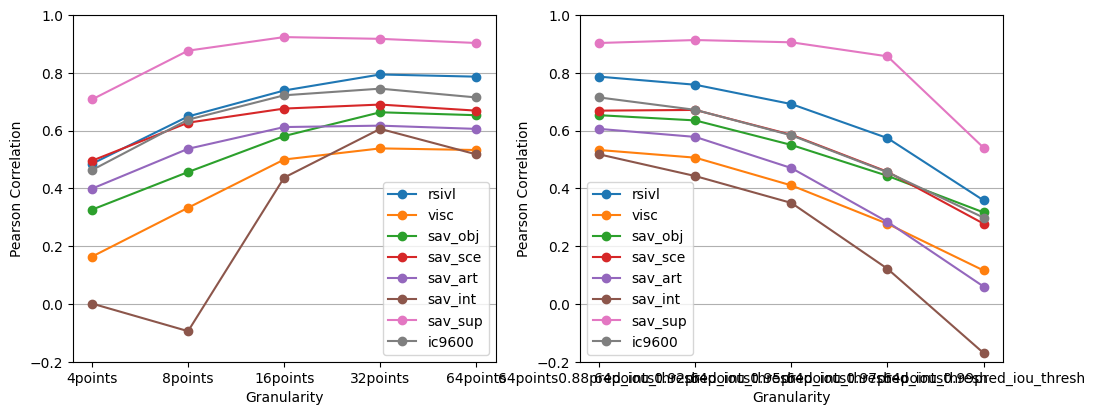

In [20]:
plot_column_against_others("complexity", "complexity", correlations, correlations2)

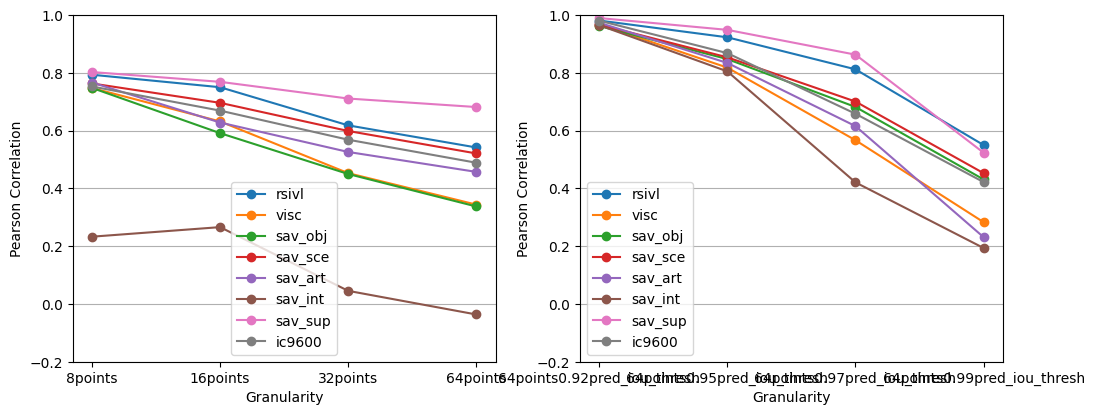

In [21]:
plot_column_against_others("4points", "64points0.88pred_iou_thresh", correlations, correlations2)

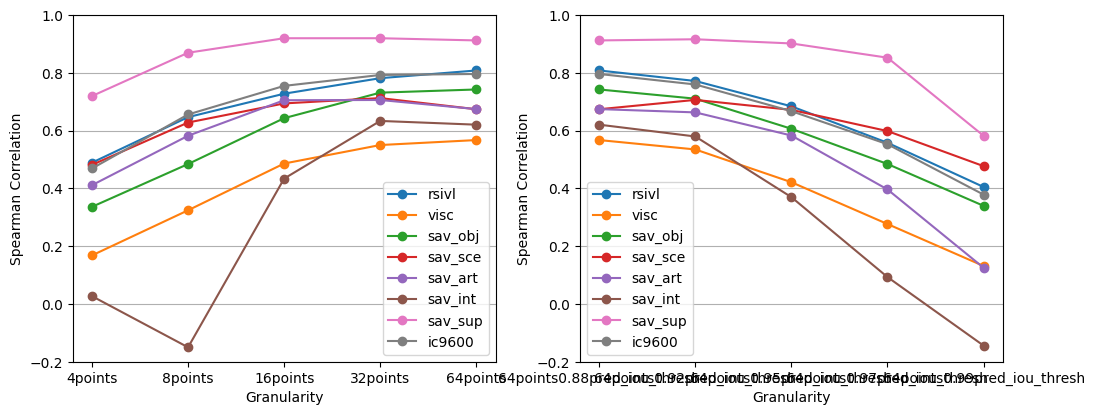

In [22]:
plot_column_against_others("complexity", "complexity", spearmans, spearmans2, "Spearman")

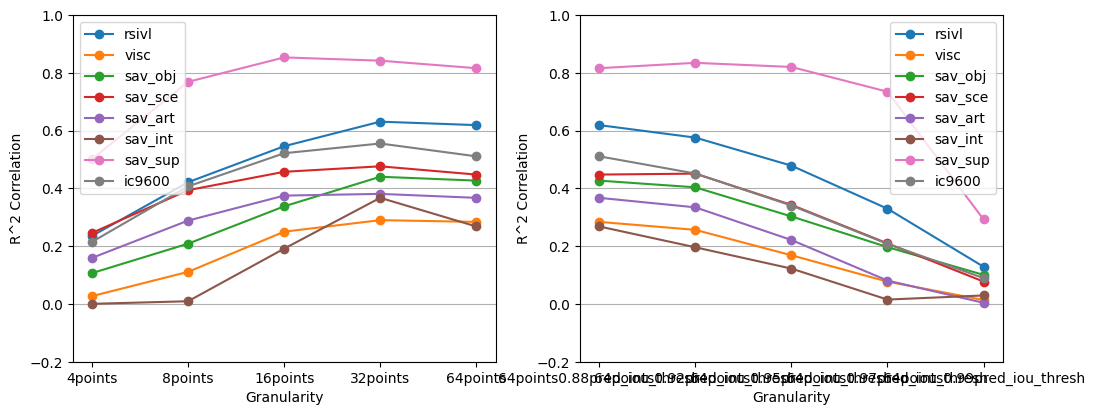

In [27]:
plot_column_against_others("complexity", "complexity", r2_correlations, r2_correlations2, "R^2")

## VISC by Category

In [130]:
import json
with open('/ptmp/tshen/shared/VISCHEMA_SUN/file_categories.json', 'r') as f:
    file_to_cats = json.load(f)

In [131]:
data['visc']['category'] = data['visc']['filename'].map(file_to_cats)

In [132]:
corr_cat, spearman_cat = {}, {}

for c in data['visc']['category'].unique():

    corr_cat[c] = {}
    spearman_cat[c] = {}
    columns = ['complexity'] + levels

    for i in range(len(columns)):
        corr_cat[c][columns[i]] = {}
        spearman_cat[c][columns[i]] = {}
        for j in range(i+1, len(columns)):
            df = data['visc']
            df = df[df['category'] == c]
            corr_cat[c][columns[i]][columns[j]] = stats.pearsonr(df[columns[i]], df[columns[j]])
            spearman_cat[c][columns[i]][columns[j]] = stats.spearmanr(df[columns[i]], df[columns[j]])

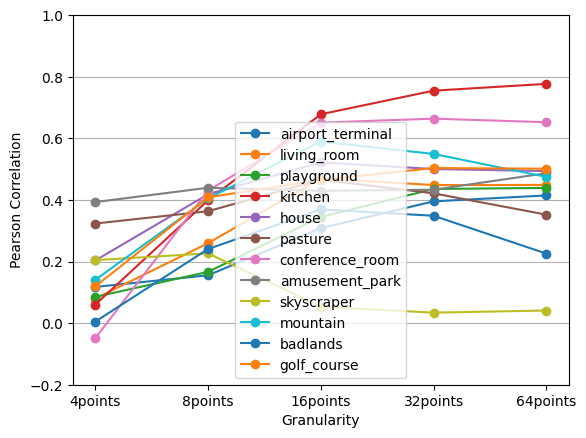

In [133]:
plt.figure()
for c in data['visc']['category'].unique():
    plt.plot(corr_cat[c]['complexity'].keys(), [x.statistic for x in corr_cat[c]['complexity'].values()], label=c, marker='o')

plt.ylim(-0.2, 1.0)
plt.grid(axis='y')
plt.xlabel("Granularity")
plt.ylabel("Pearson Correlation")
plt.legend()


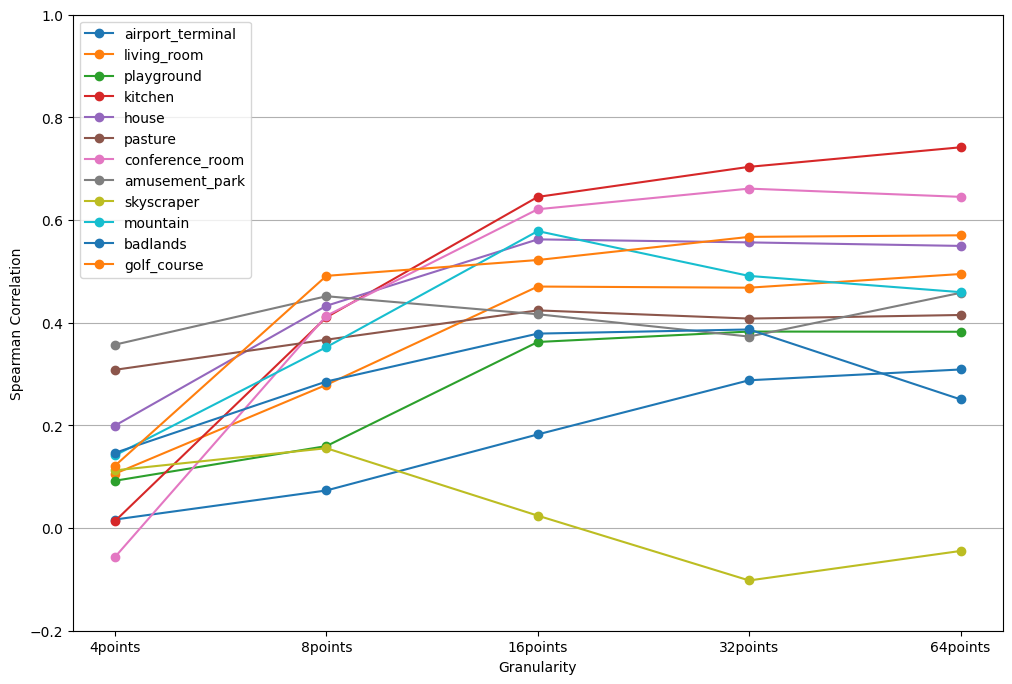

In [145]:
plt.figure(figsize=(12, 8))
for c in data['visc']['category'].unique():
    plt.plot(spearman_cat[c]['complexity'].keys(), [x.statistic for x in spearman_cat[c]['complexity'].values()], label=c, marker='o')

plt.ylim(-0.2, 1.0)
plt.grid(axis='y')
plt.xlabel("Granularity")
plt.ylabel("Spearman Correlation")
plt.legend()


/tmp/ipykernel_22293/2725919764.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


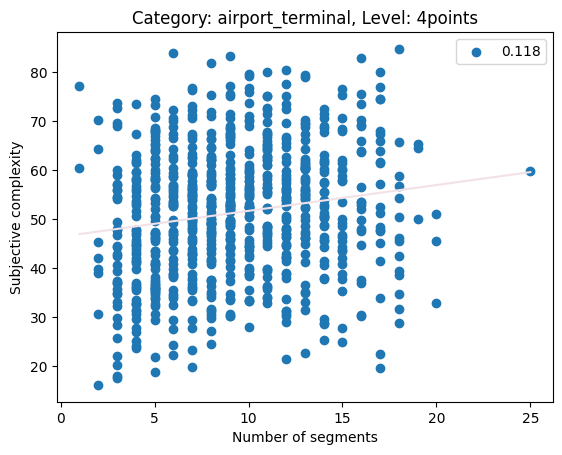

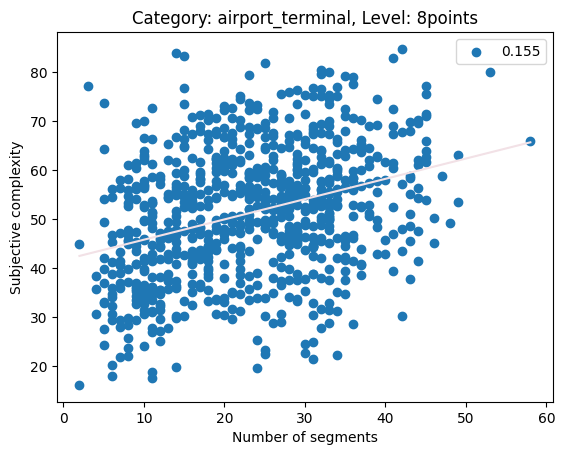

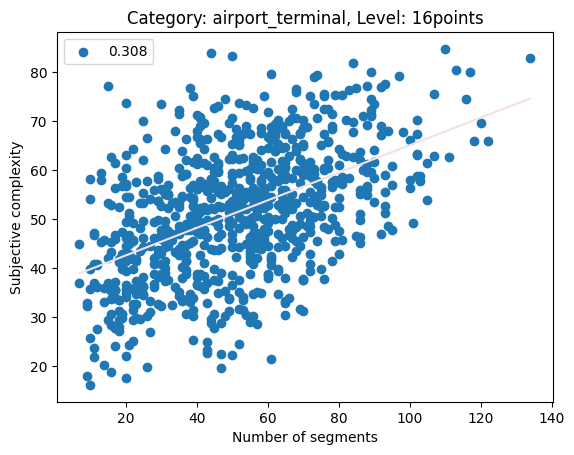

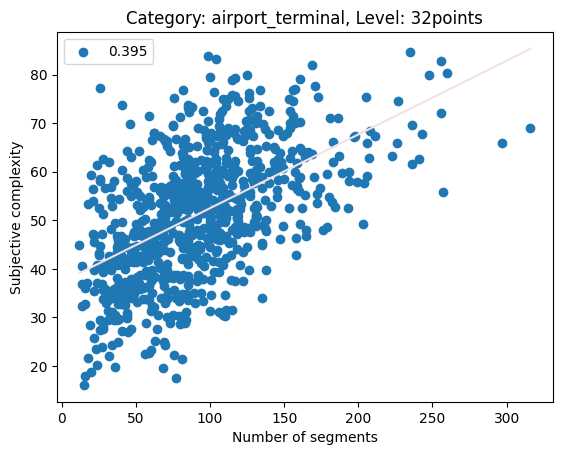

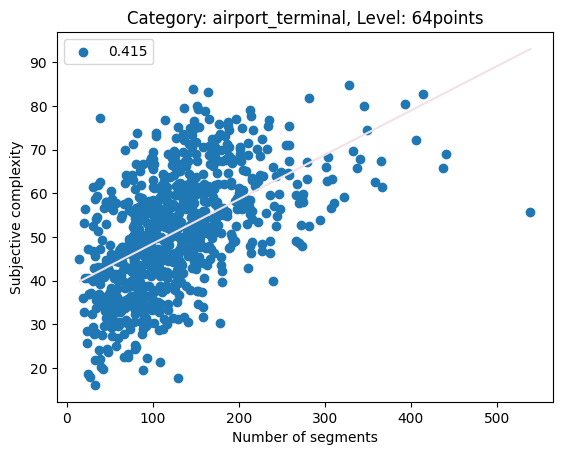

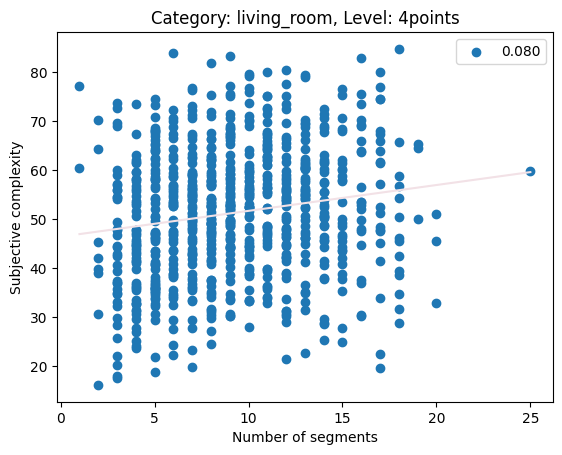

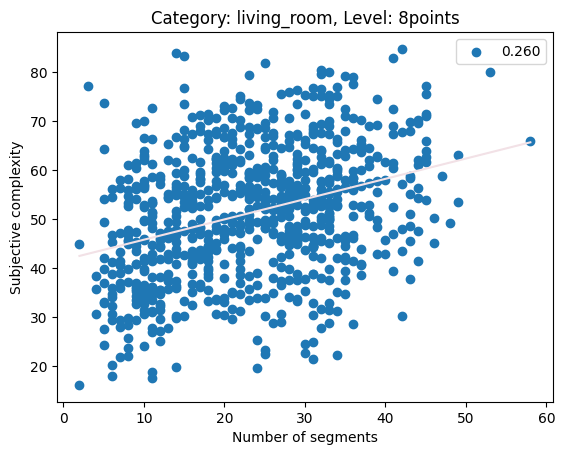

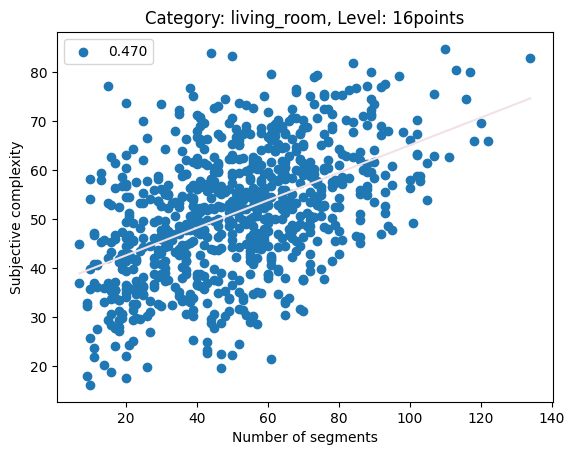

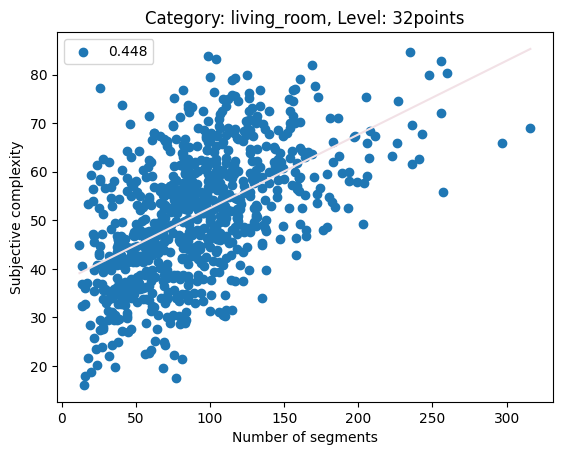

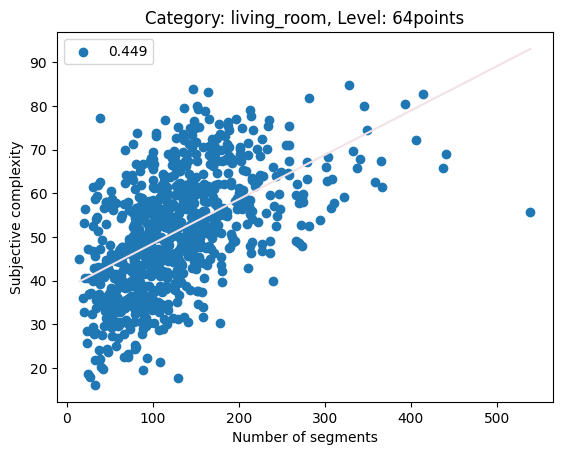

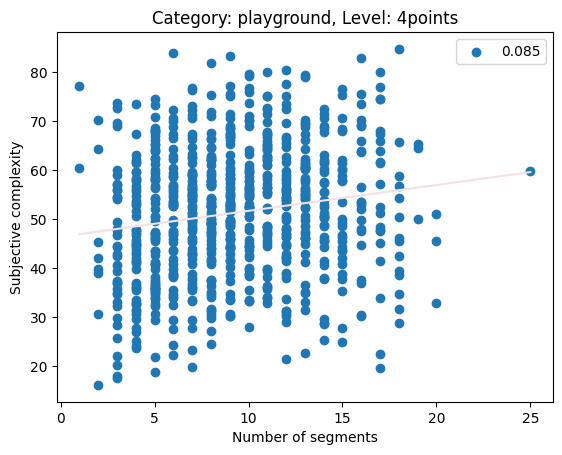

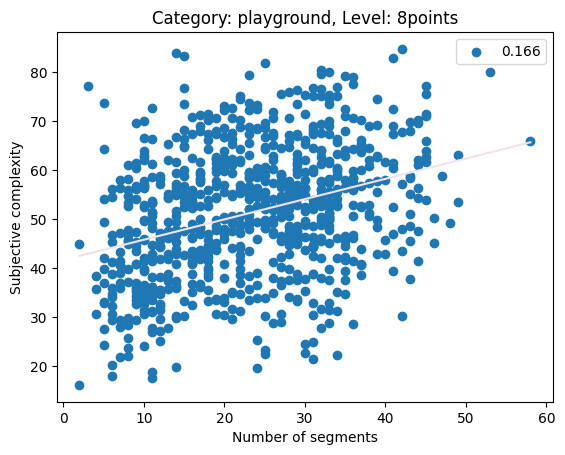

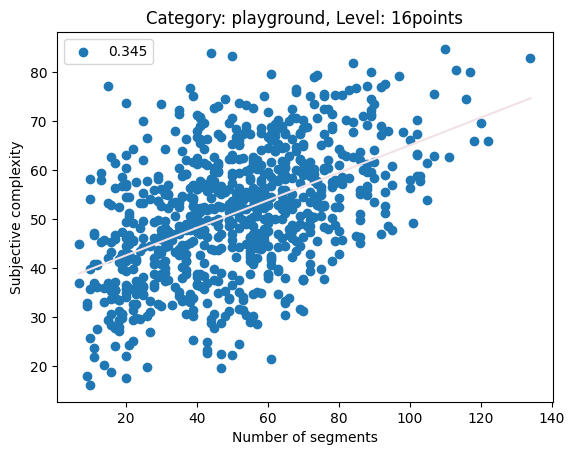

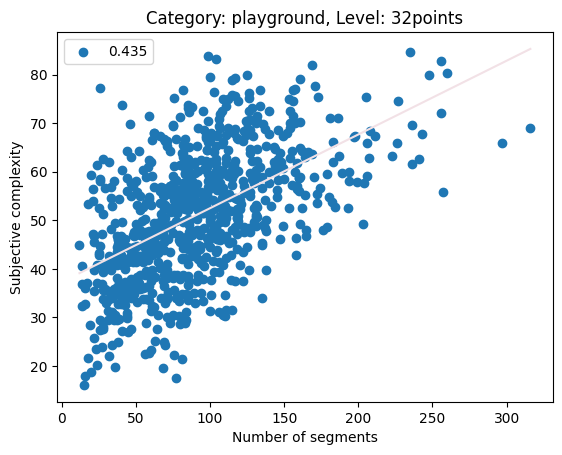

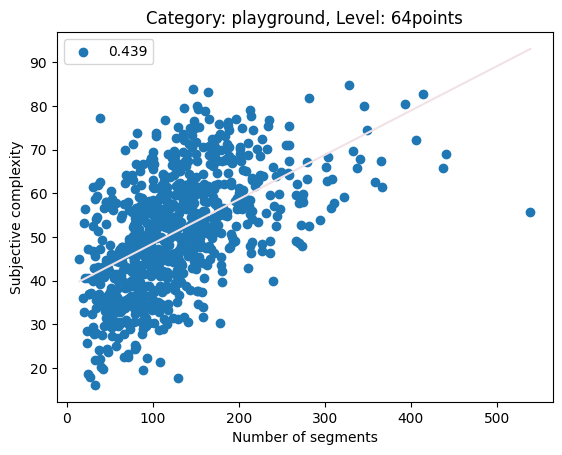

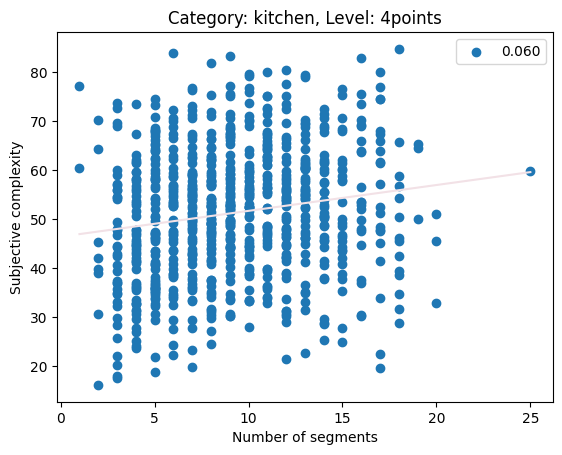

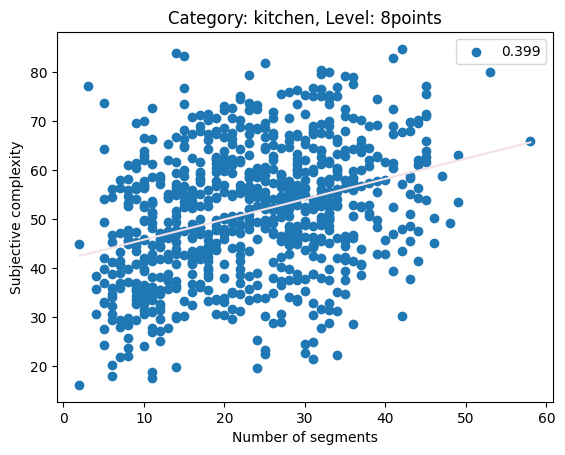

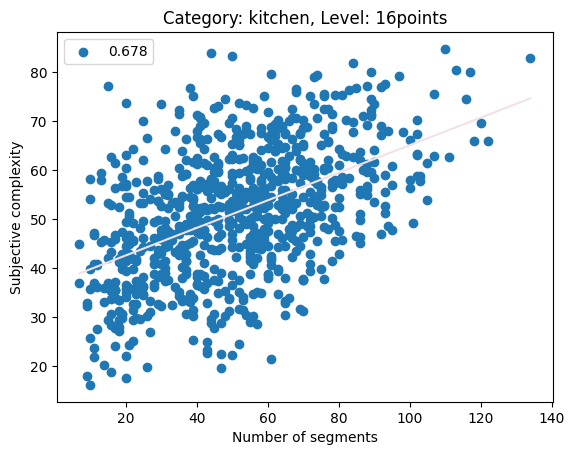

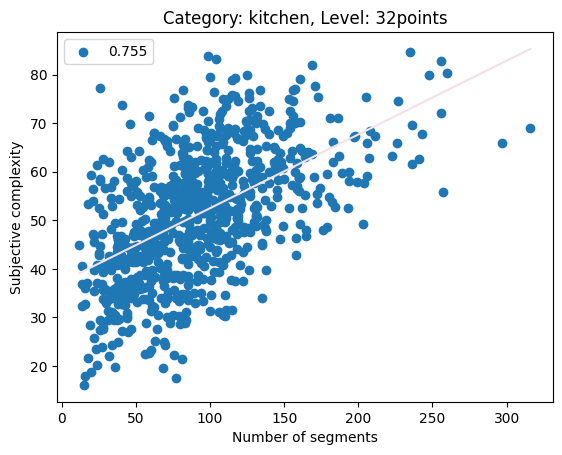

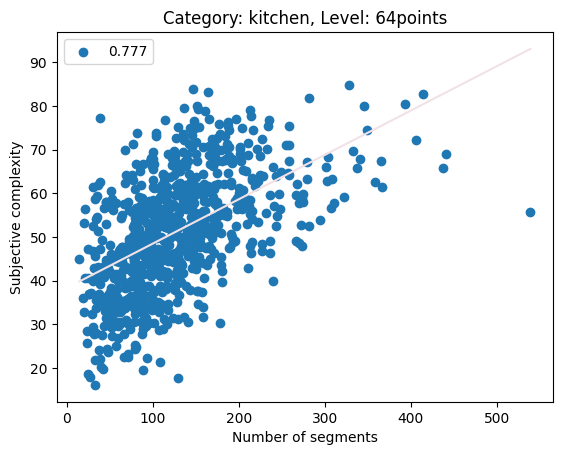

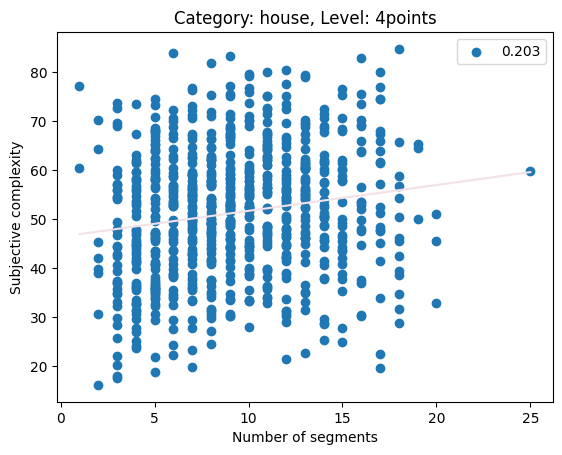

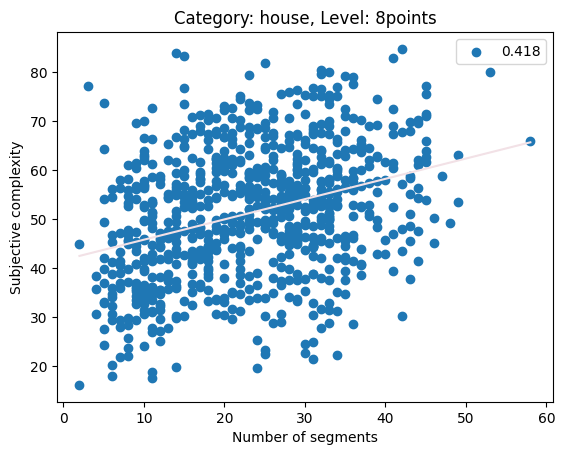

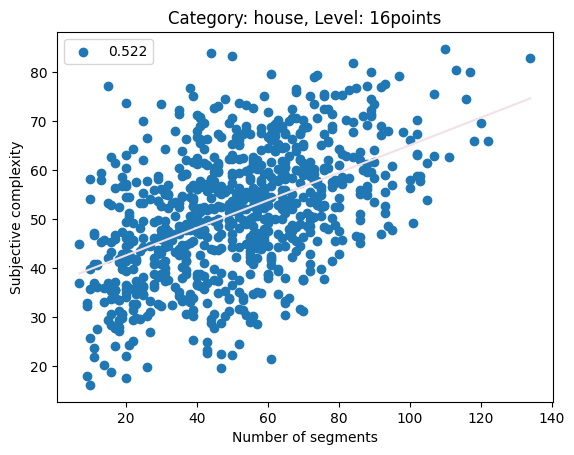

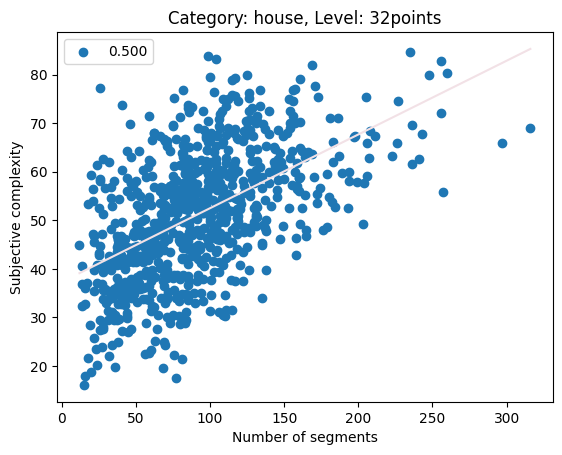

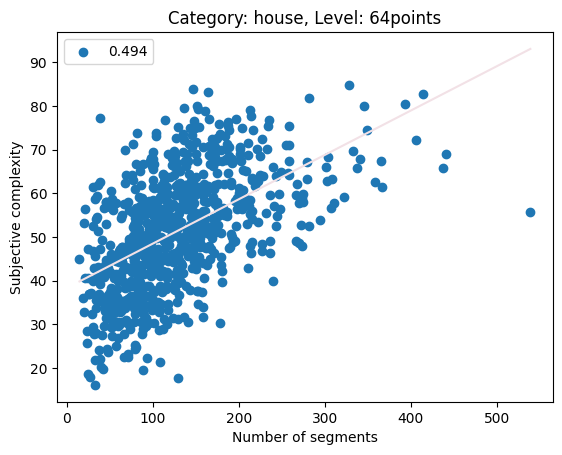

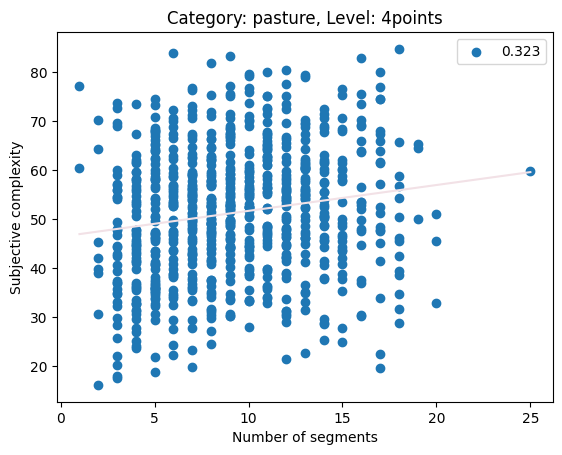

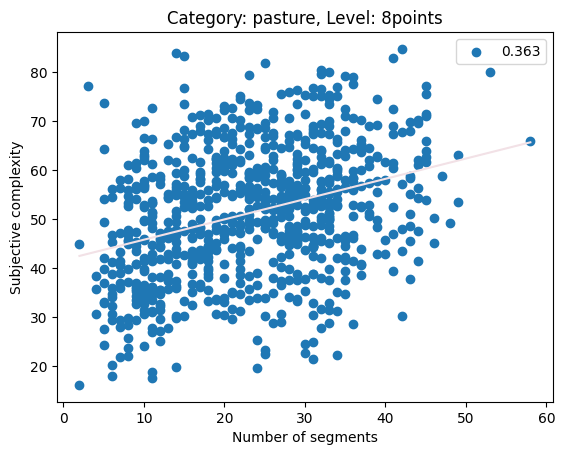

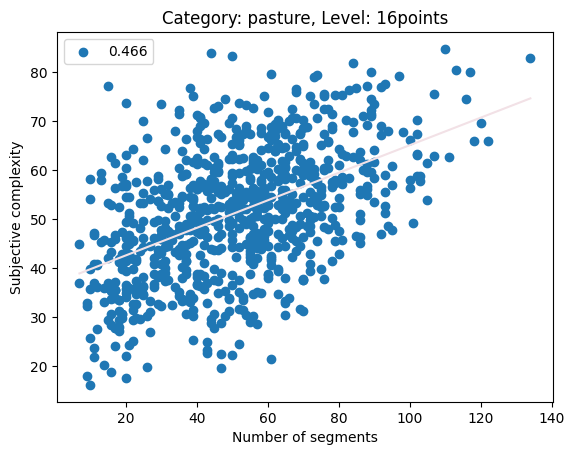

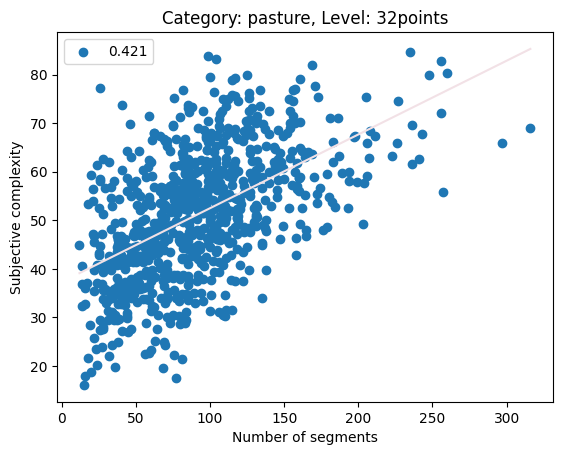

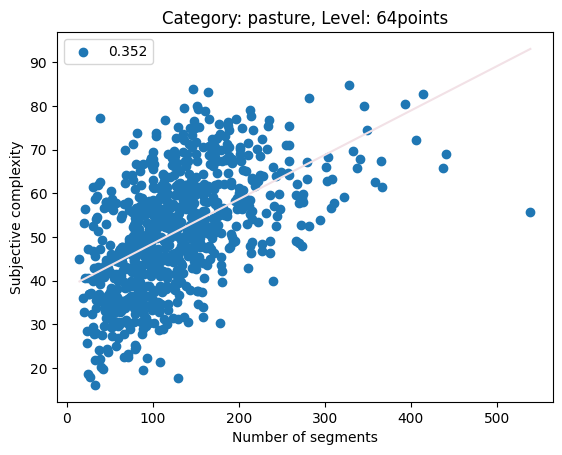

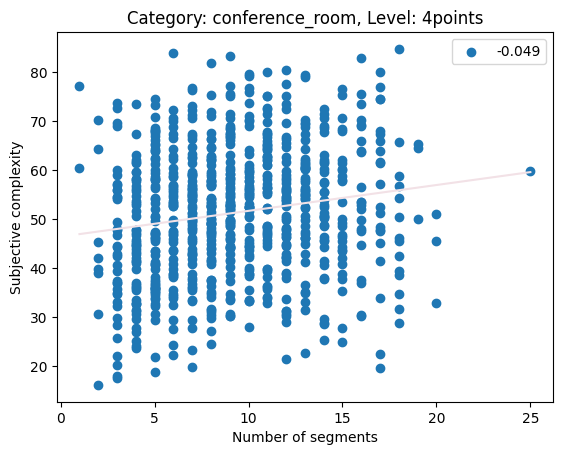

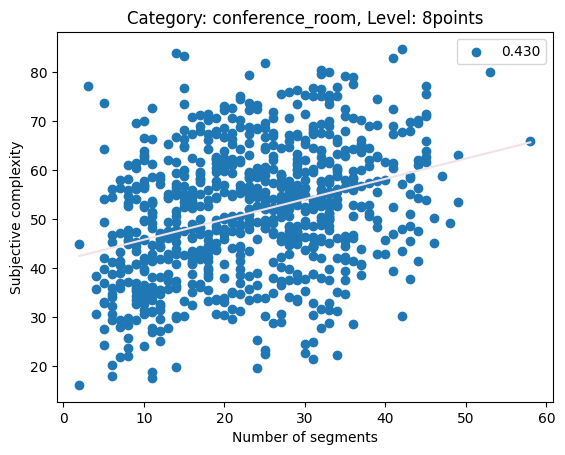

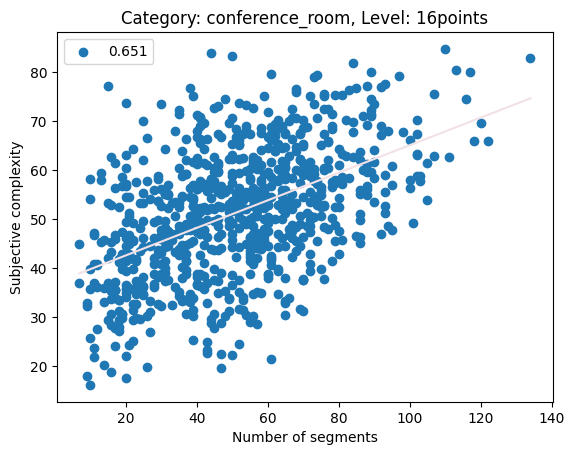

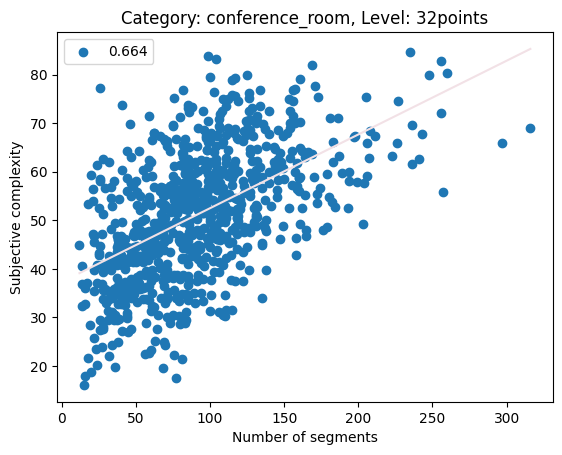

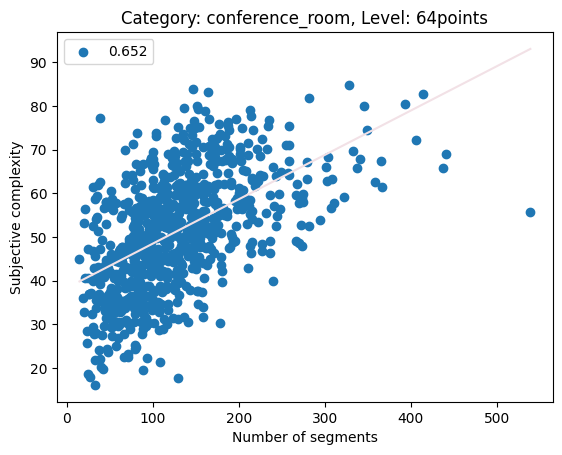

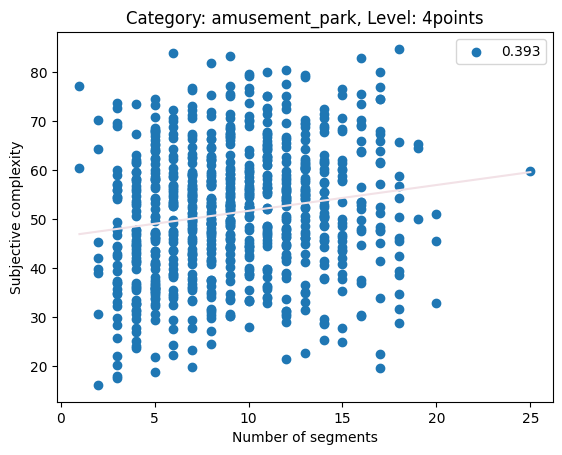

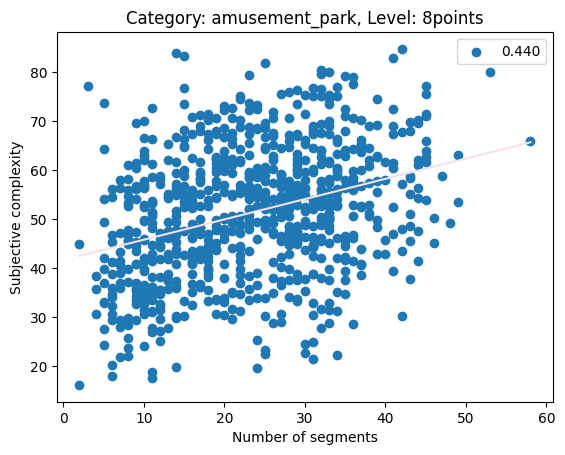

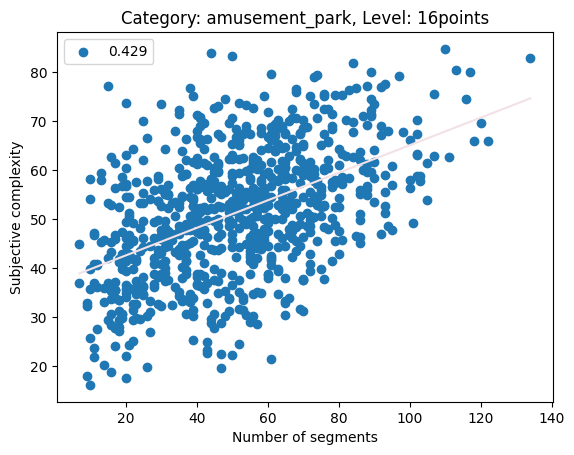

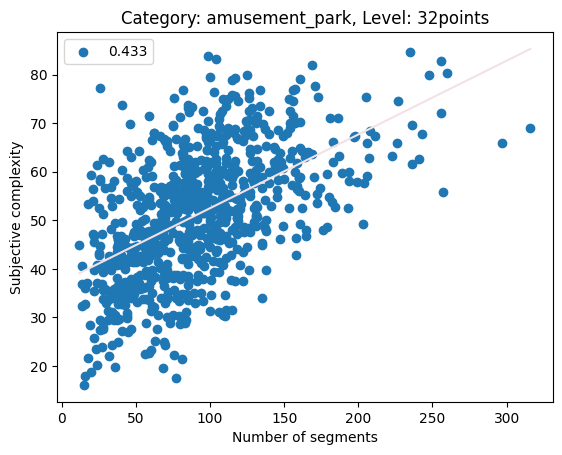

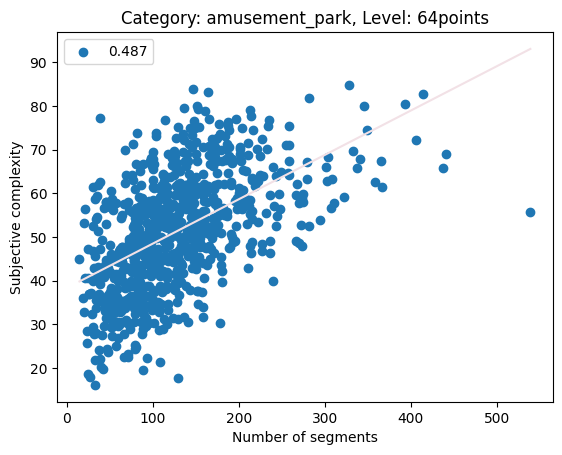

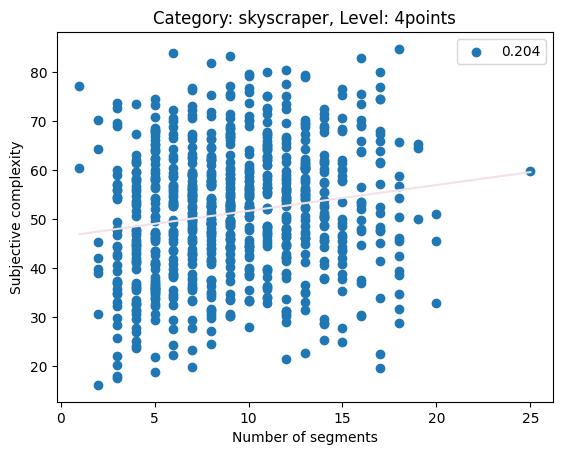

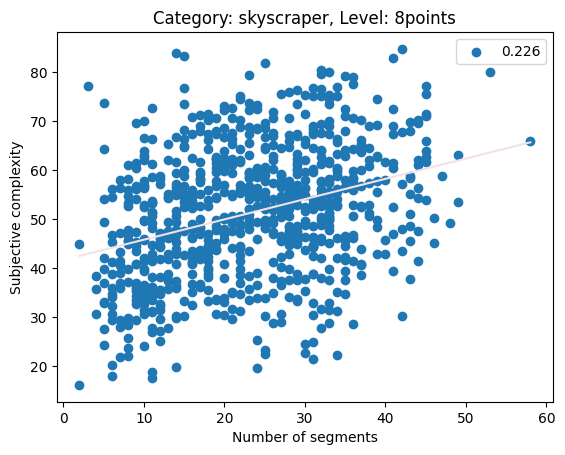

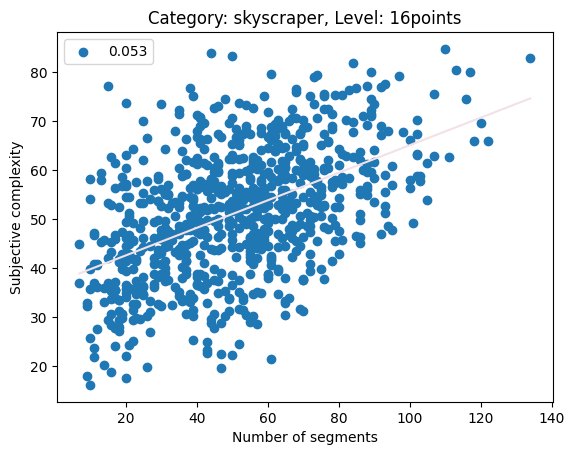

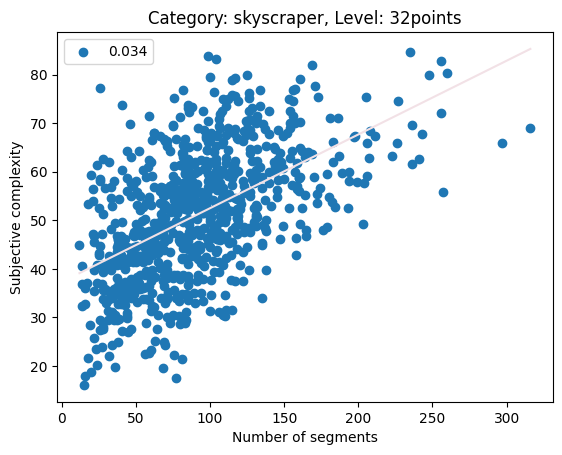

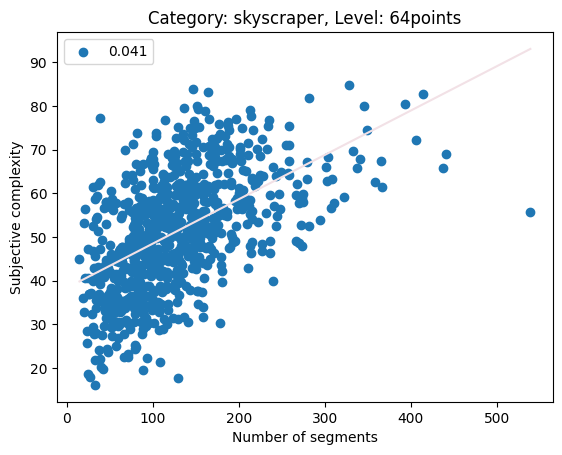

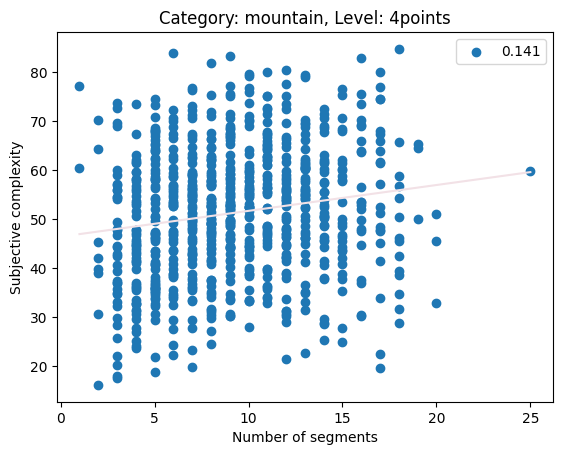

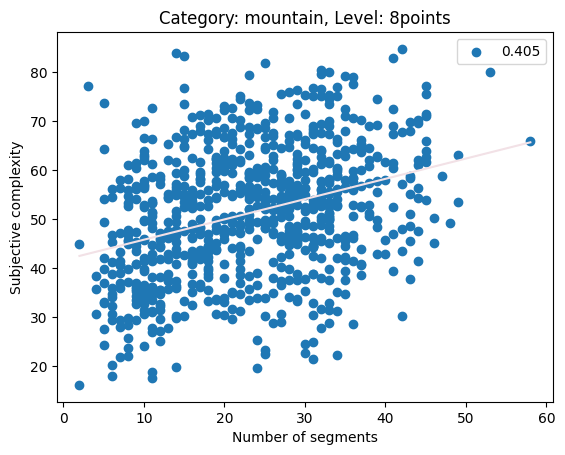

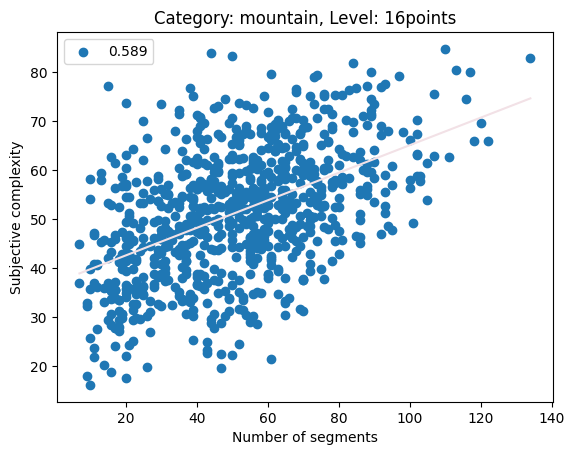

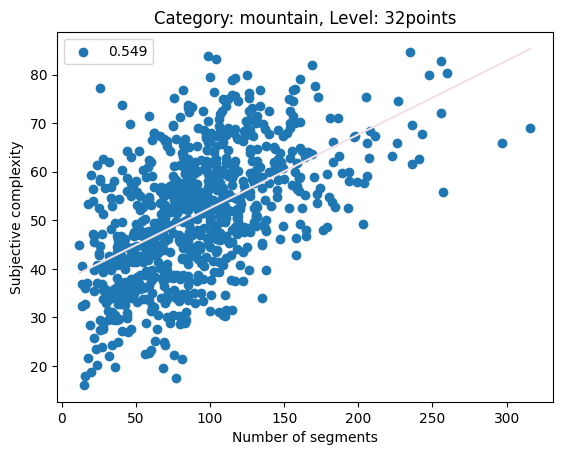

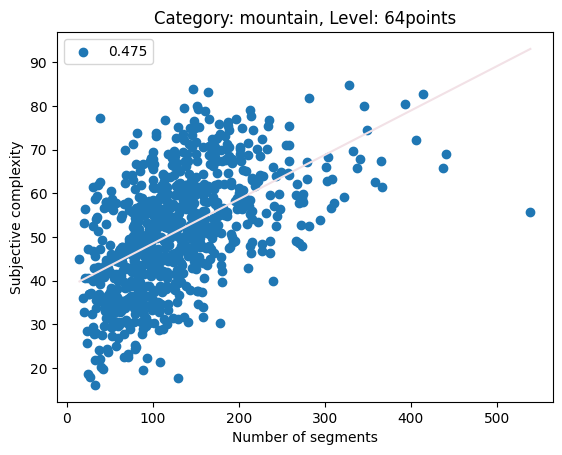

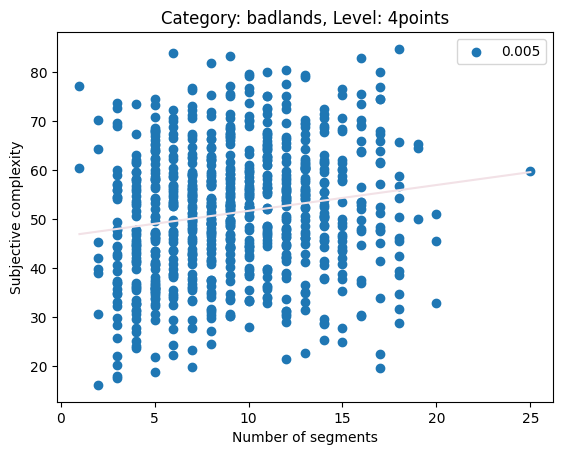

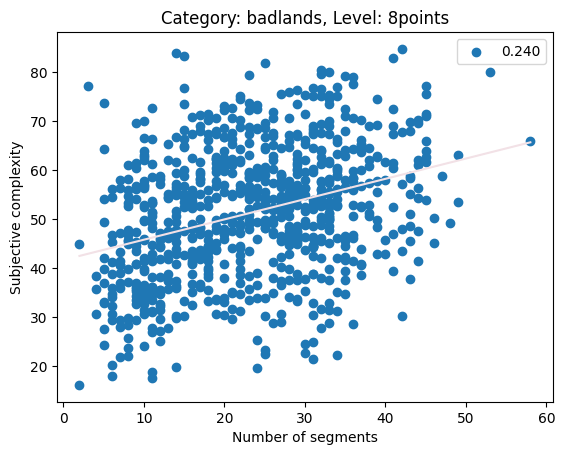

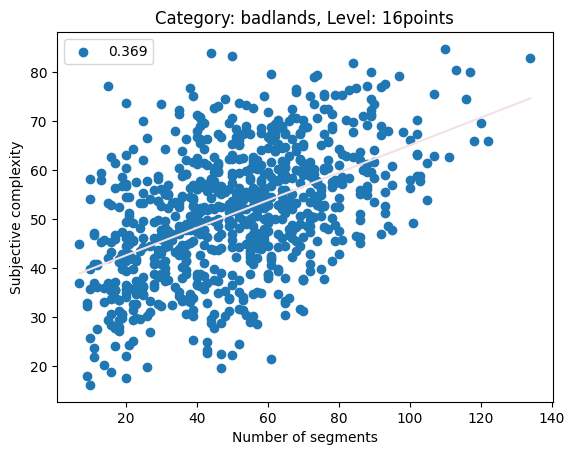

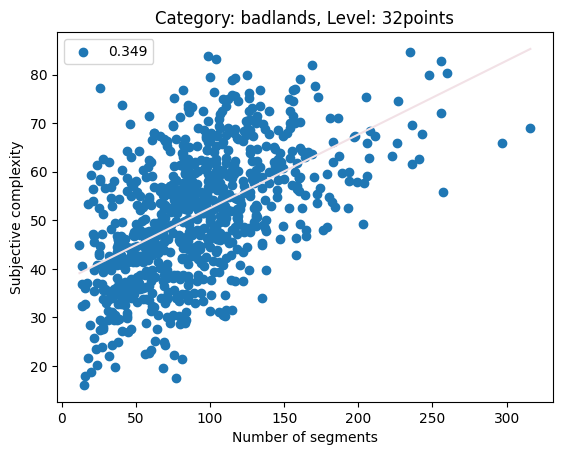

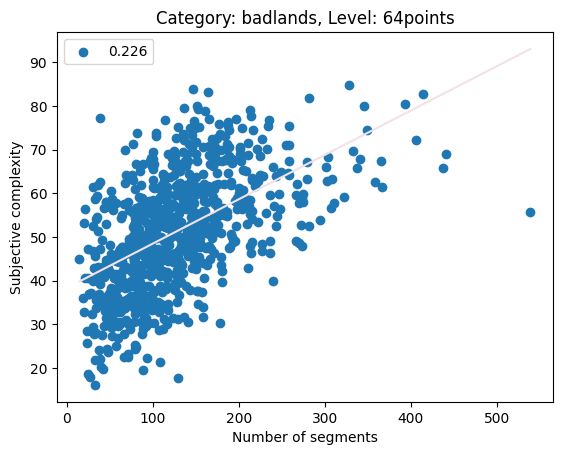

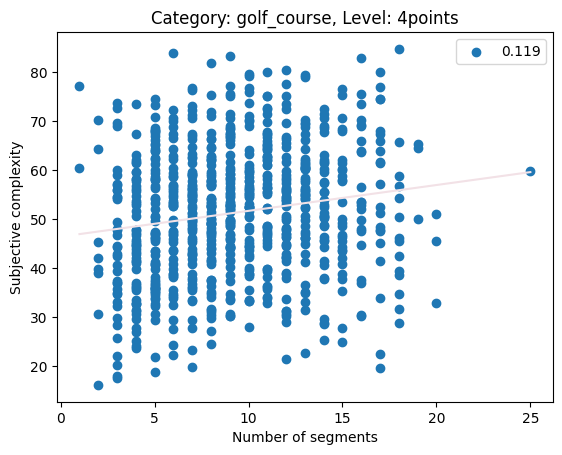

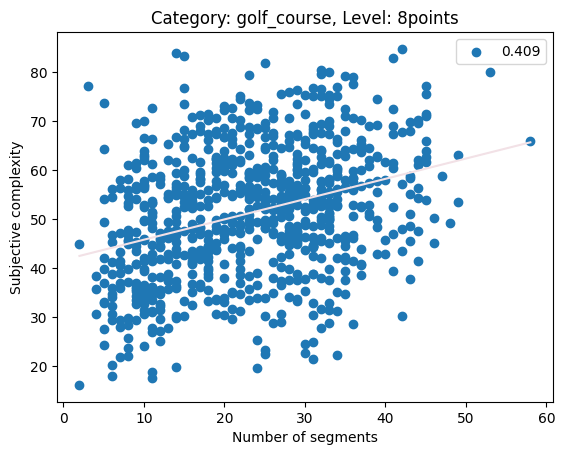

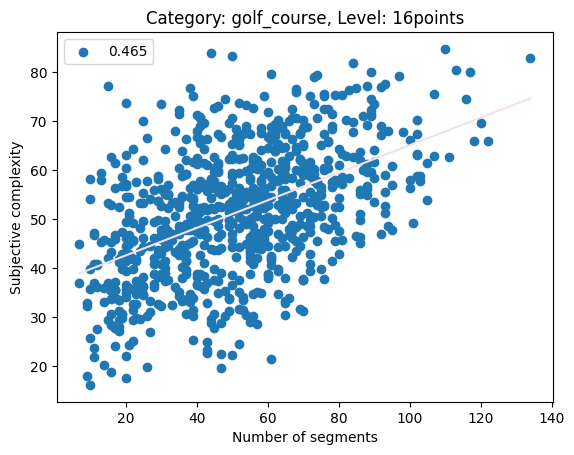

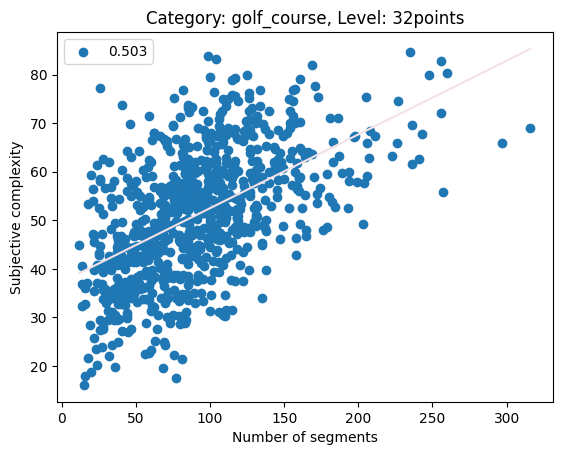

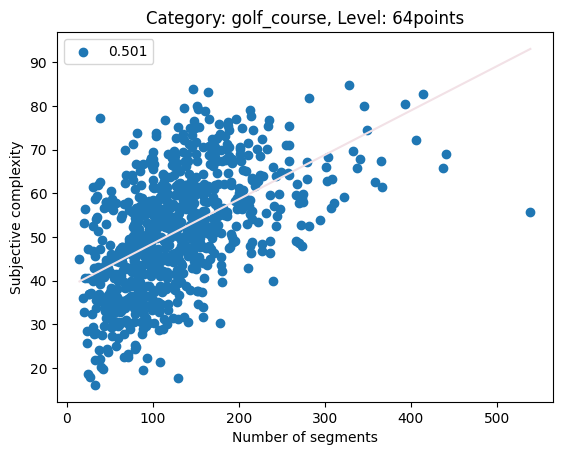

In [135]:
for c in data['visc']['category'].unique():
    df = data['visc']
    df = df[df['category']==c] 
    for level in levels:
        plt.figure()
        x = data['visc'][level]
        y = data['visc']["complexity"]
        plt.scatter(x, y, label="{:.3f}".format(corr_cat[c]['complexity'][level].statistic))
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), '#f2e1e6')
        plt.title("Category: {}, Level: {}".format(c, level))
        plt.xlabel("Number of segments")
        plt.ylabel("Subjective complexity")
        plt.legend()

# Number of Segments

In [28]:
def plot_dataset_boxplots(data, levels, dataset):
    columns = ["complexity"] + levels
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(16, 5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(dataset, fontsize=14)

    for i, c in enumerate(columns):
        axes[i].boxplot(data[dataset][c])
        axes[i].set_xlabel(c)
        ylabel = "complexity" if c == "complexity" else "number of segments"
        axes[i].set_ylabel(ylabel)

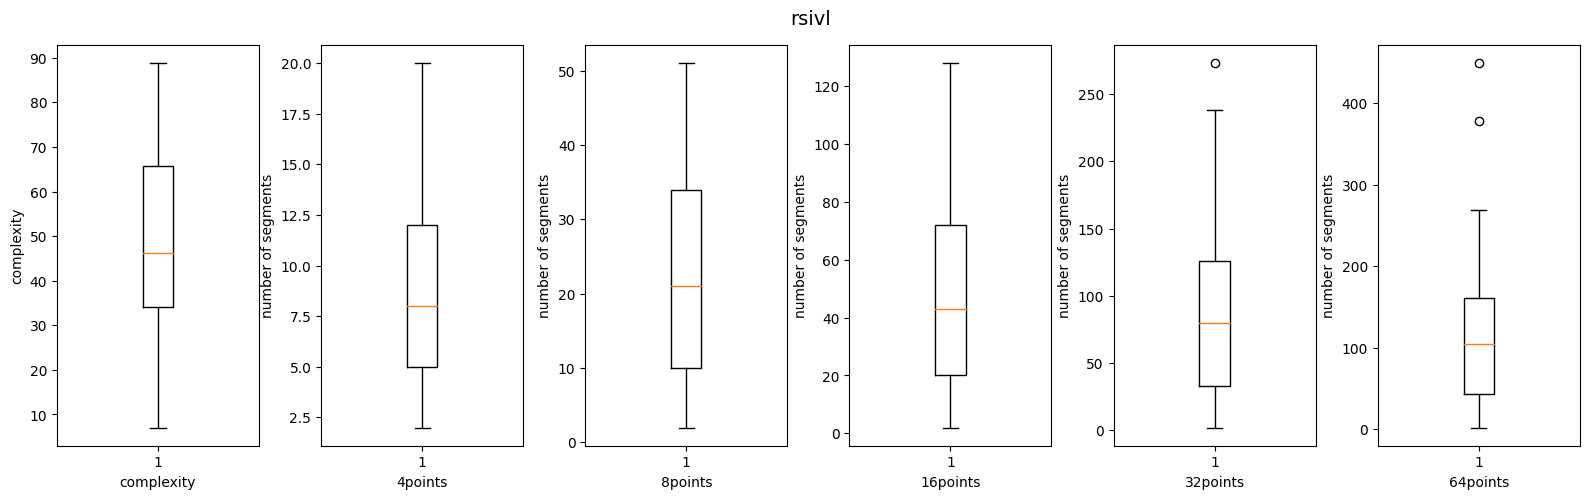

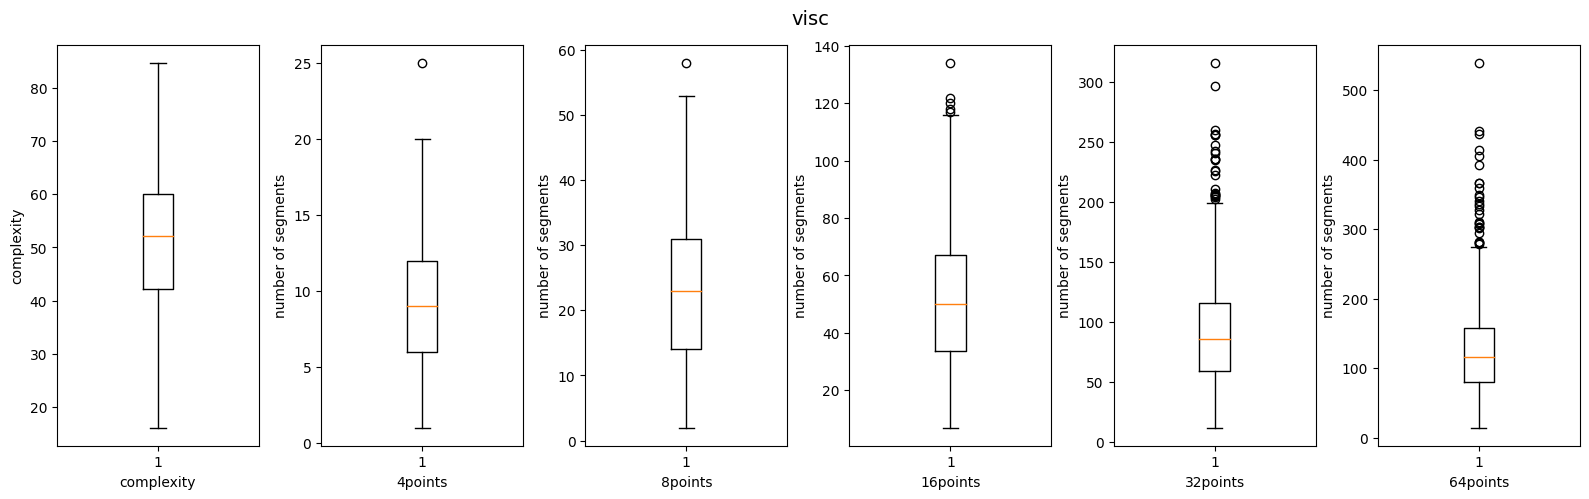

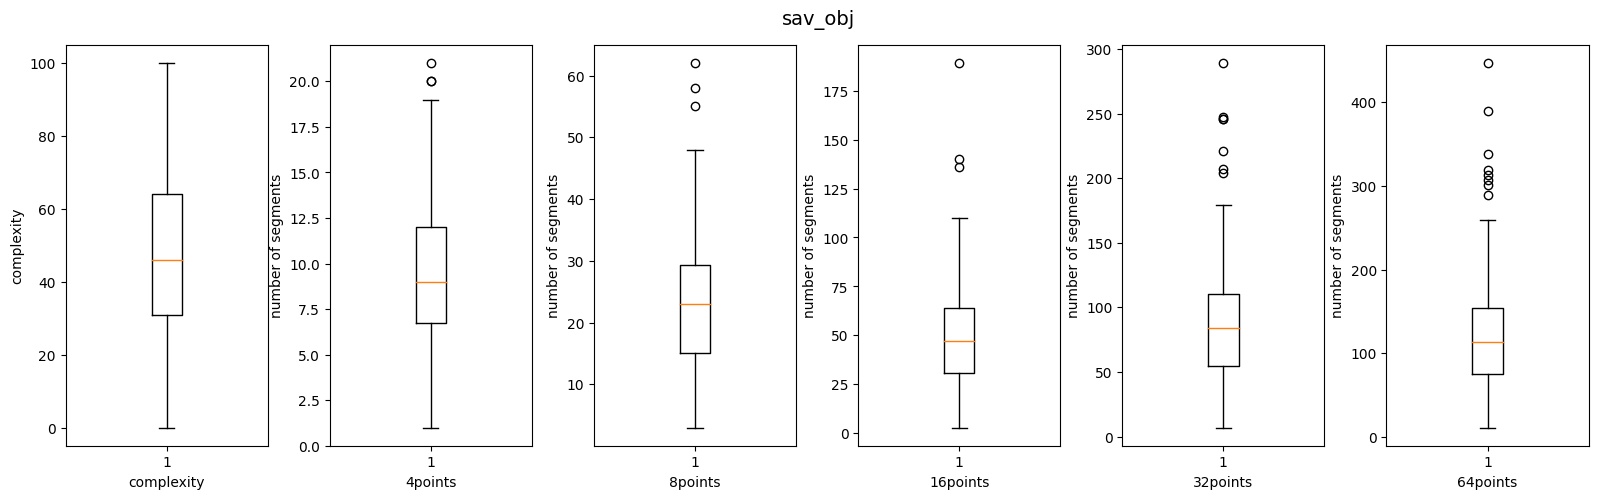

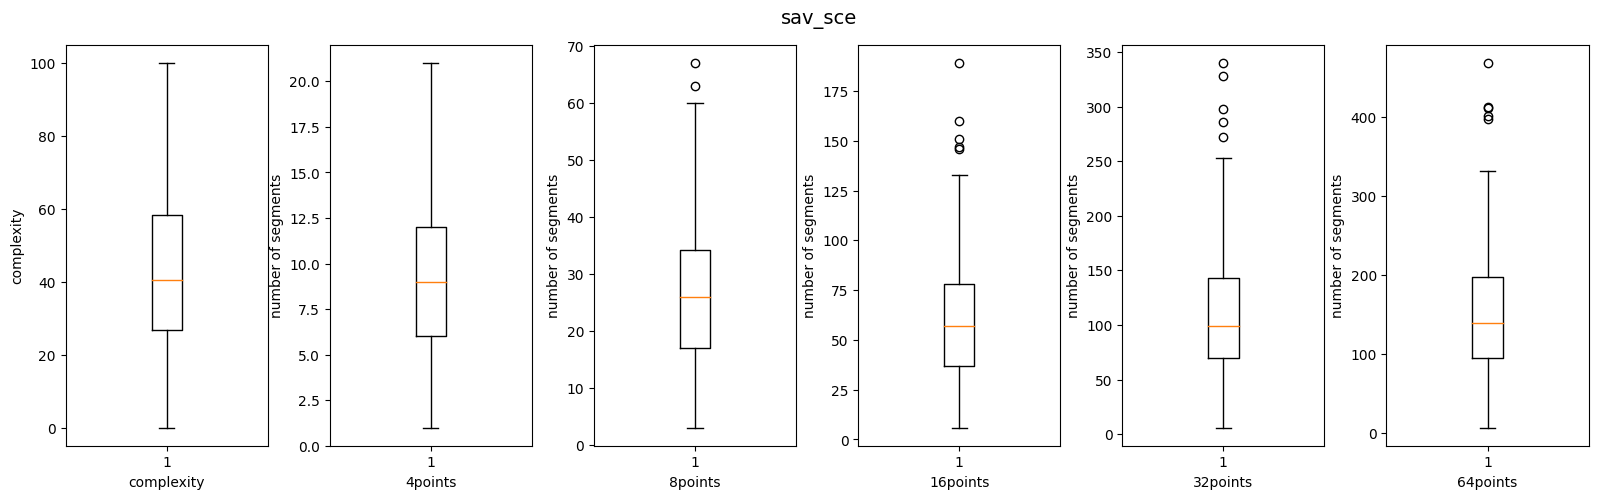

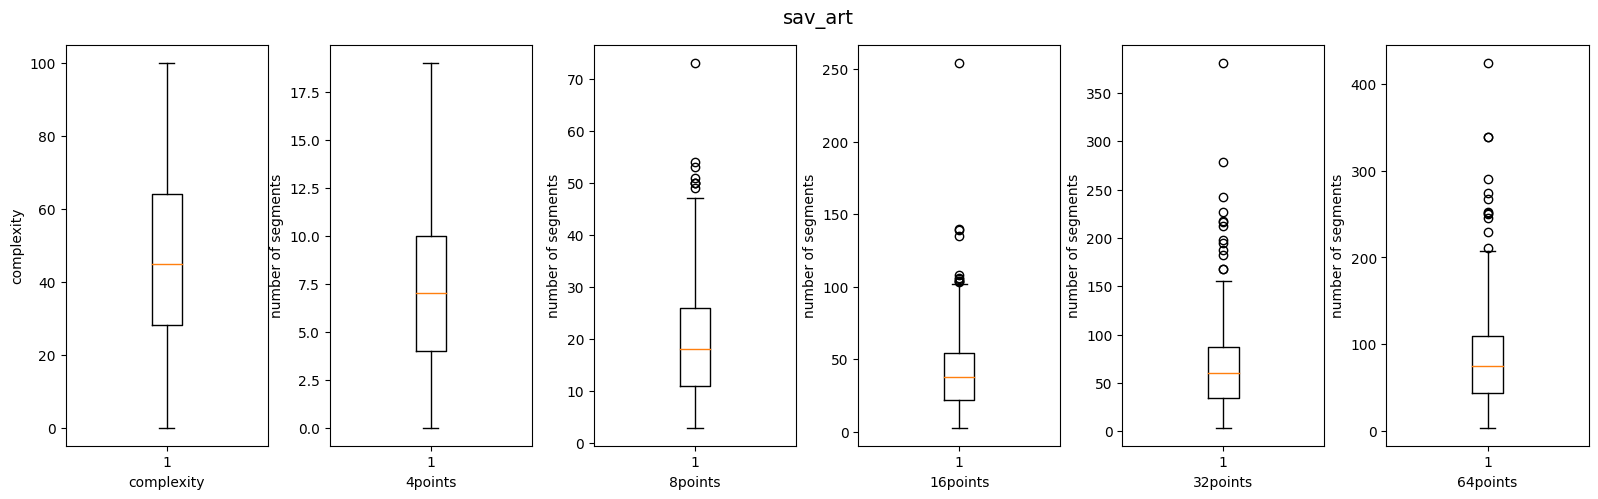

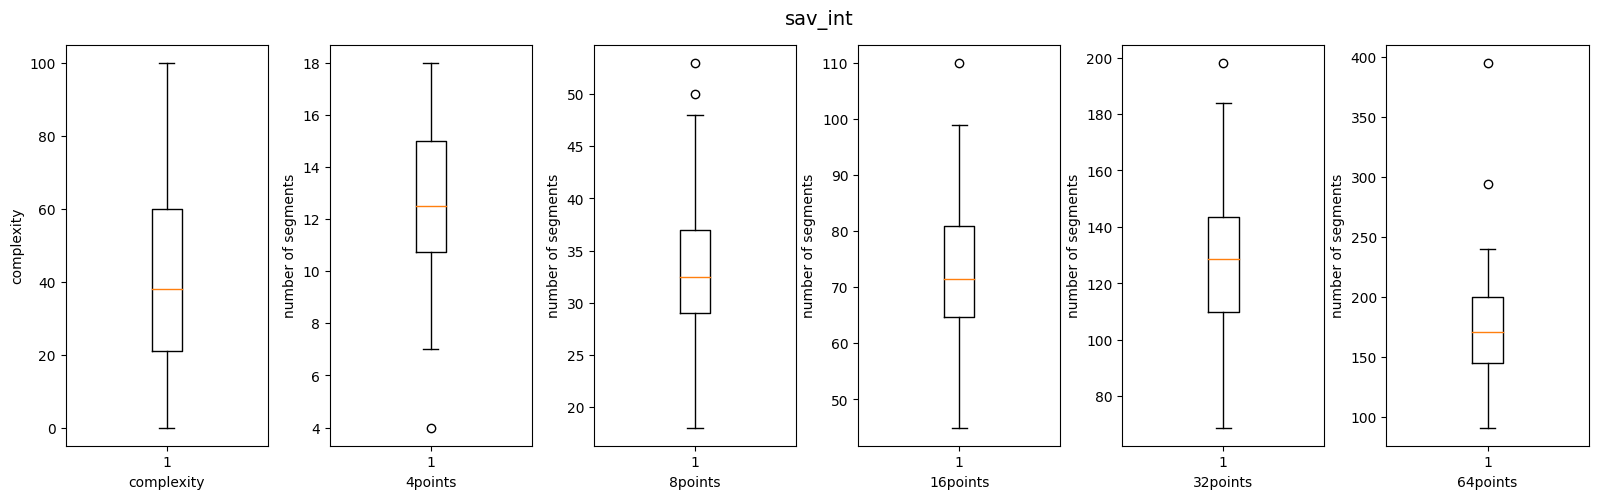

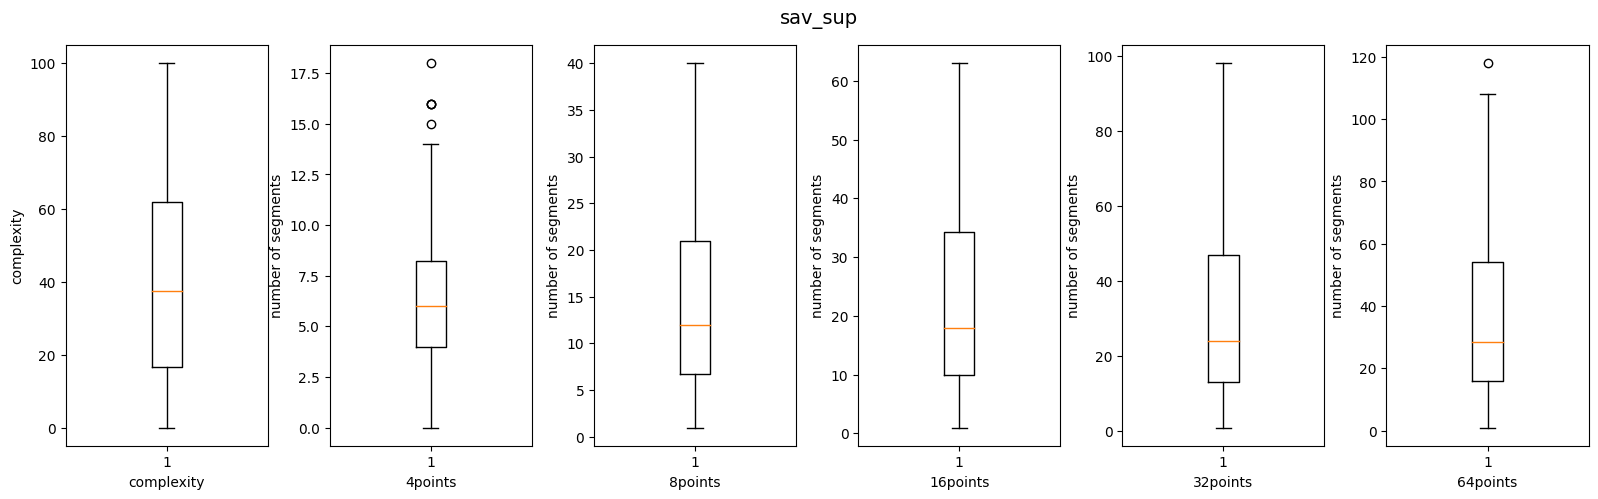

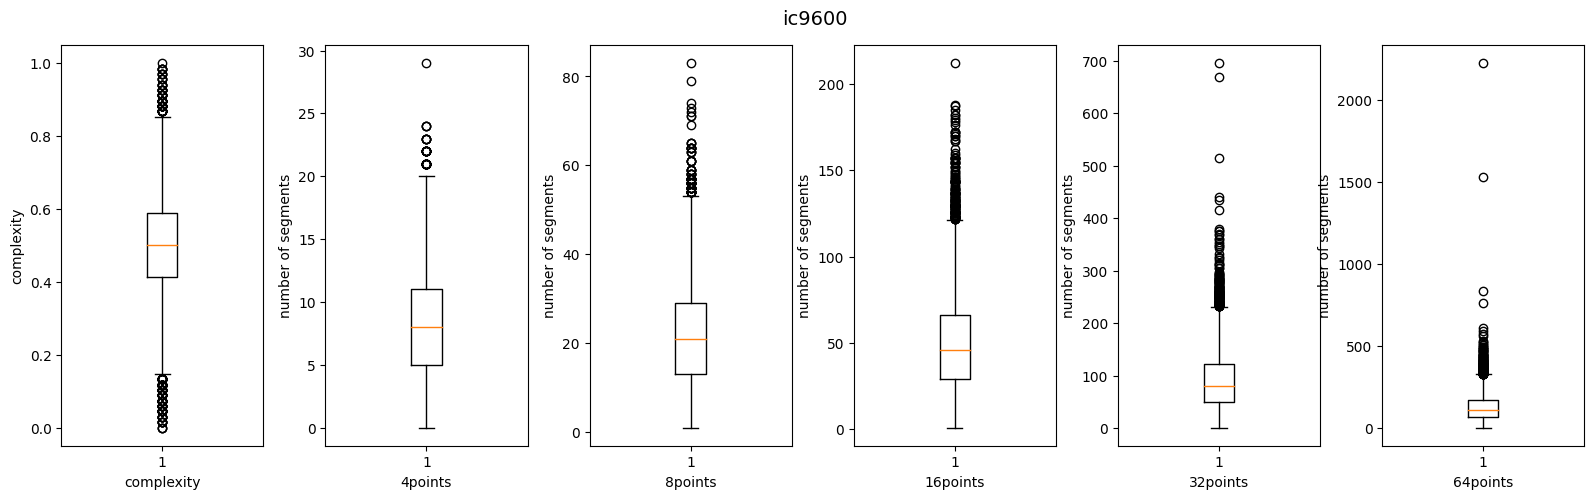

In [29]:
for dataset in data.keys():
    plot_dataset_boxplots(data, levels, dataset)

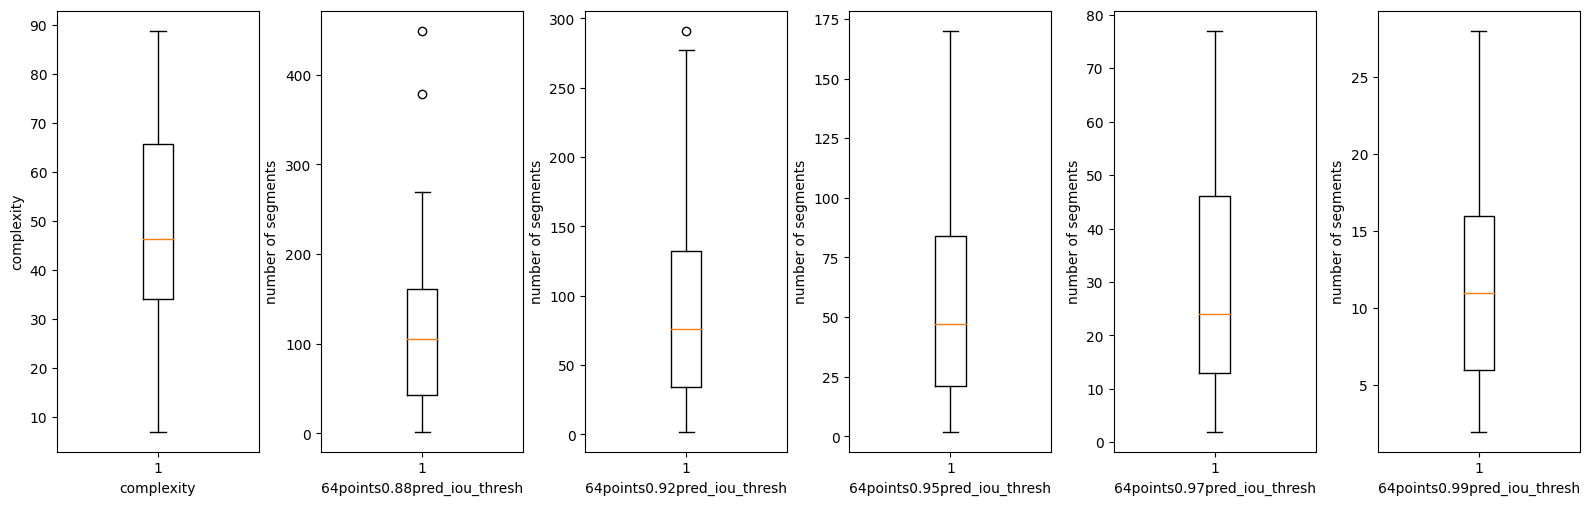

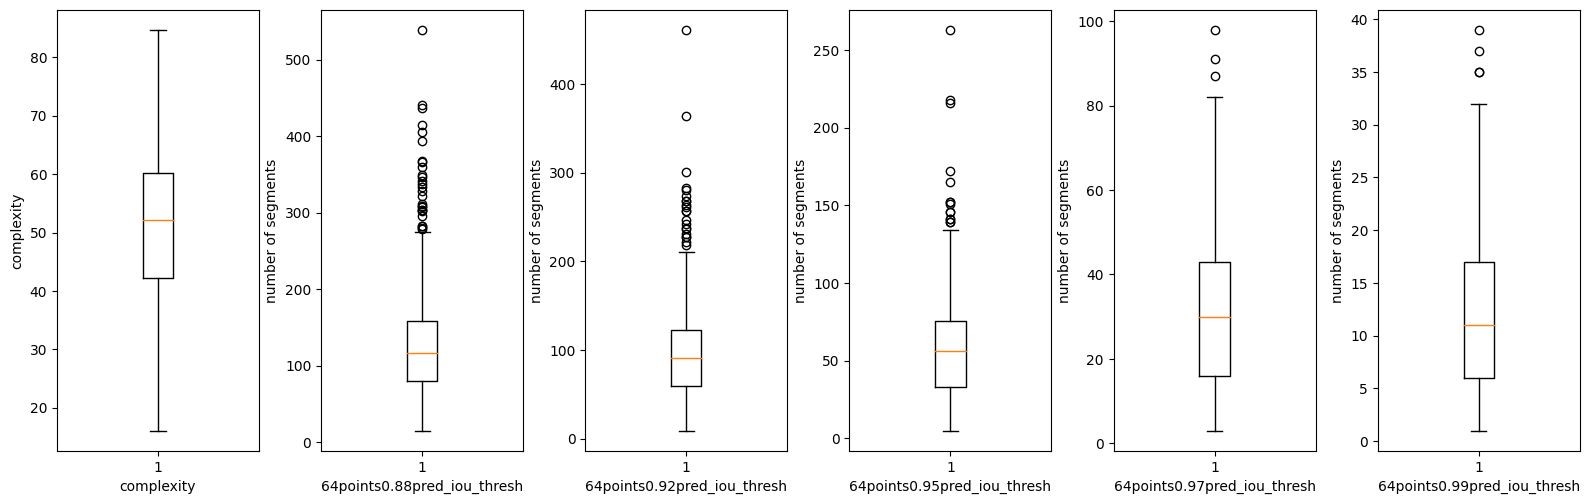

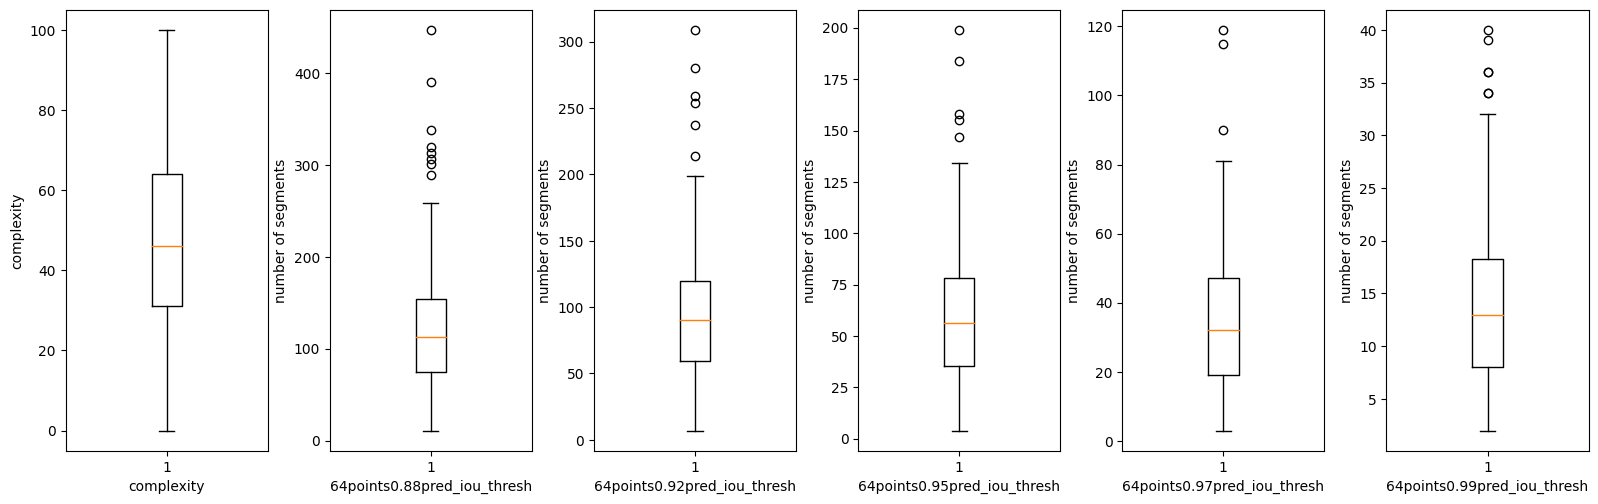

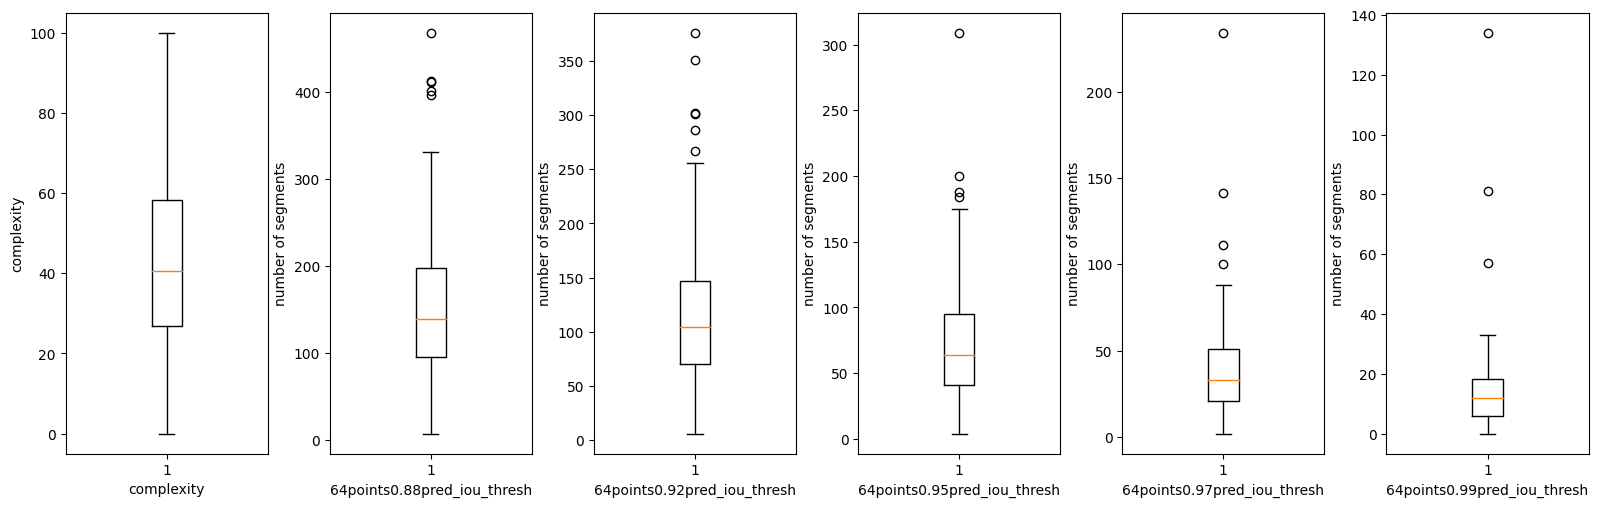

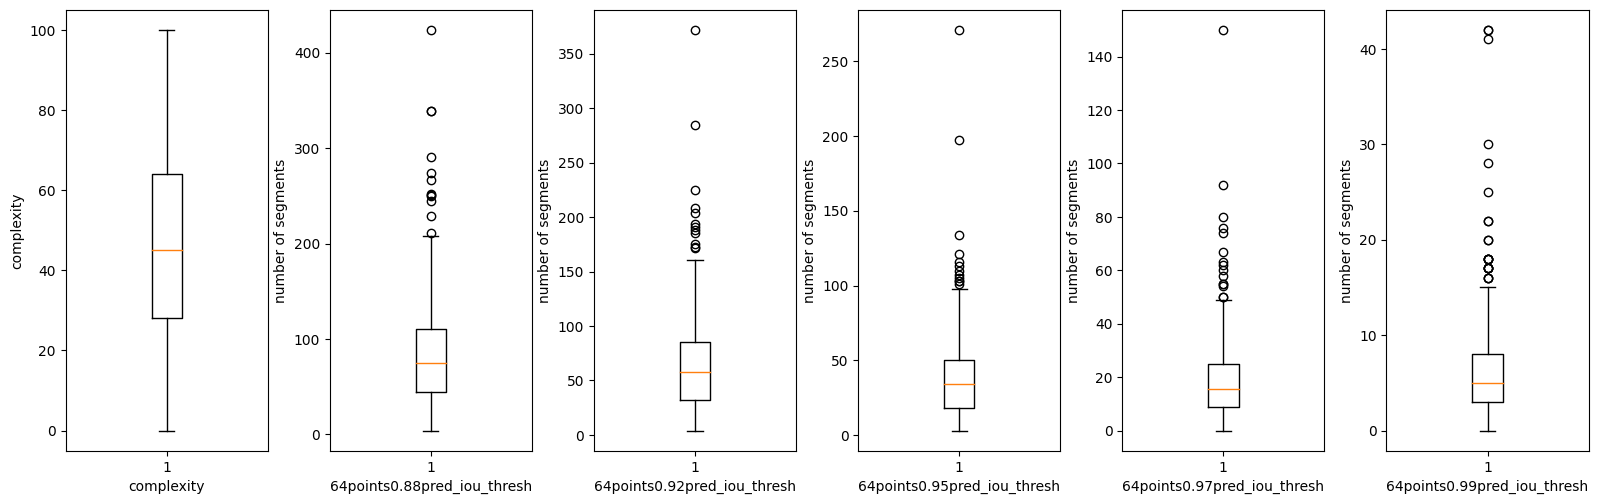

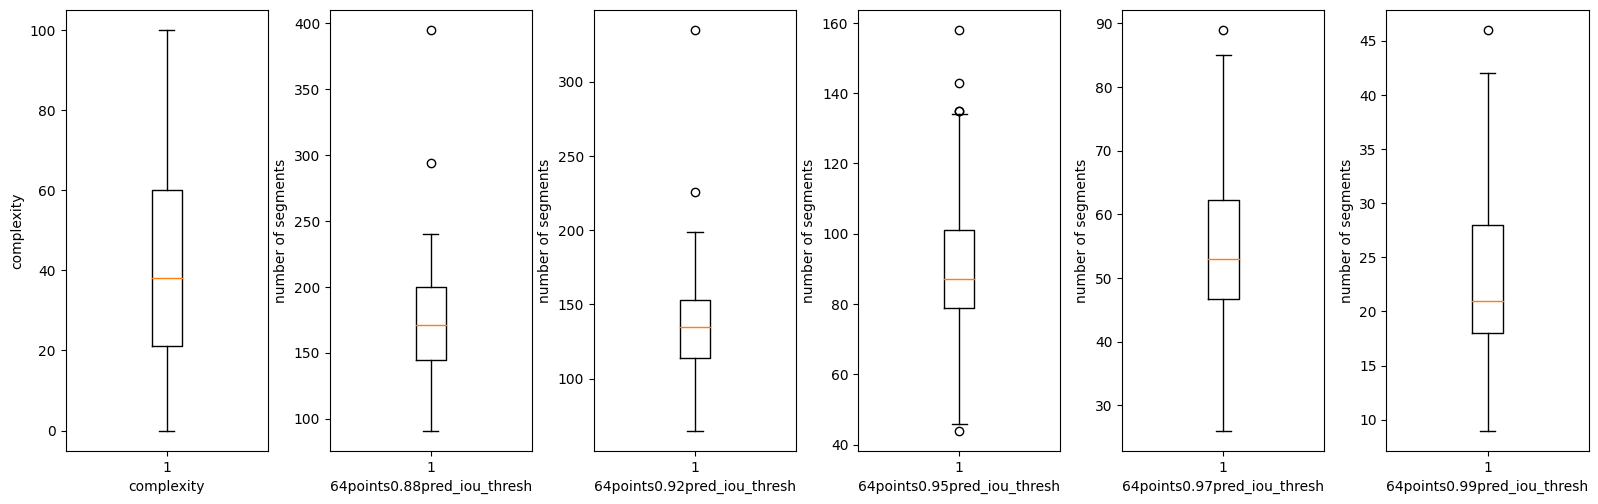

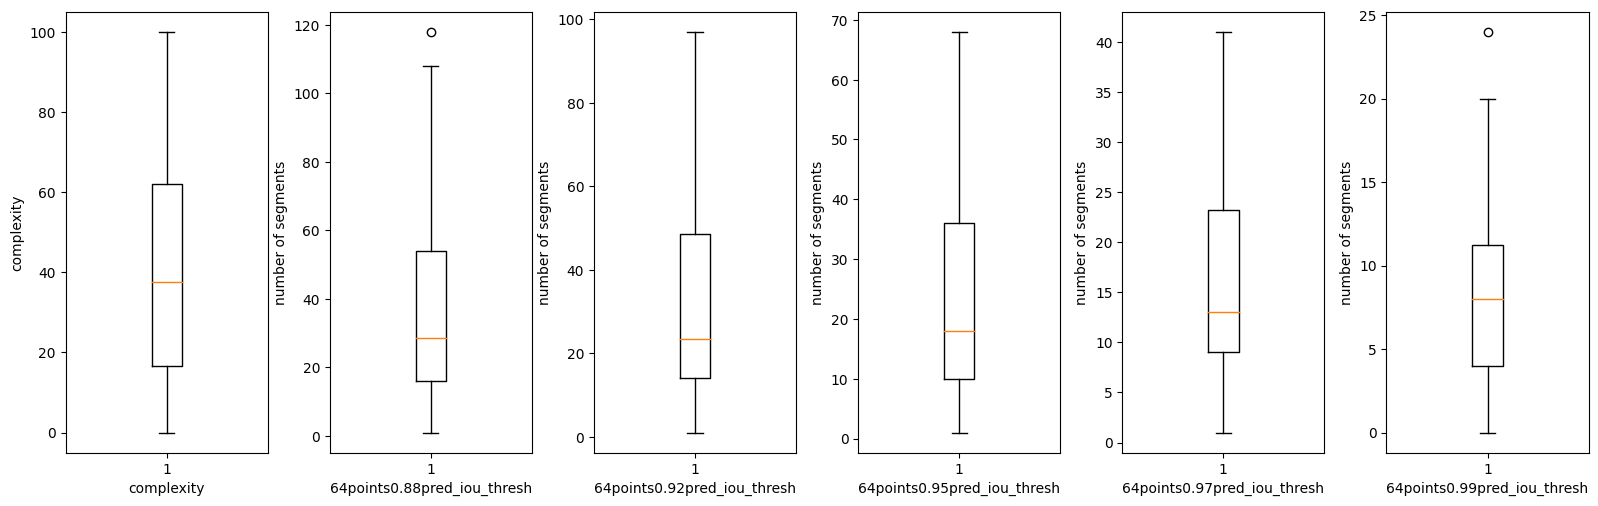

In [49]:
for dataset in data2.keys():
    plot_dataset_boxplots(data2, levels2, dataset)

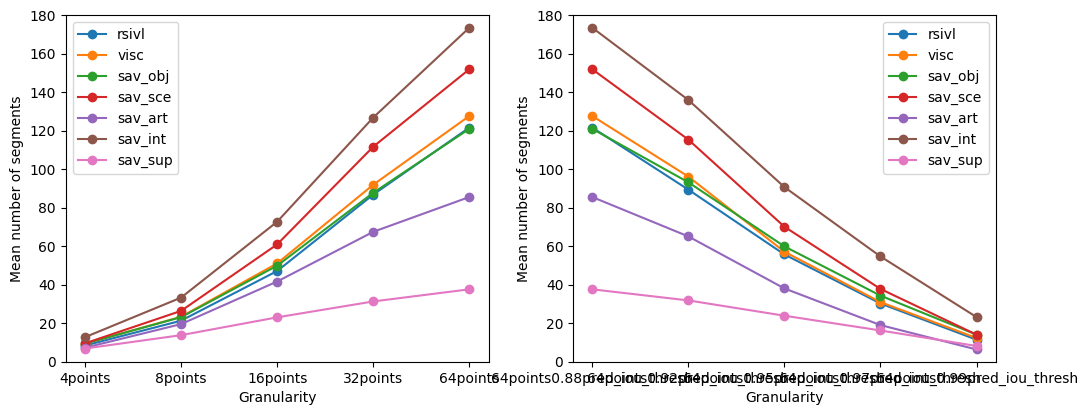

In [59]:
plt.figure(figsize=(12, 4.5))
plt.subplot(1, 2, 1)
for dataset in correlations.keys():
    plt.plot(levels, [data[dataset][l].mean() for l in levels], label=dataset, marker='o')

plt.ylim(0, 180)
plt.xlabel("Granularity")
plt.ylabel("Mean number of segments")
plt.legend()

plt.subplot(1, 2, 2)
for dataset in correlations2.keys():
    plt.plot(levels2, [data2[dataset][l].mean() for l in levels2], label=dataset, marker='o')

plt.ylim(0, 180)
plt.xlabel("Granularity")
plt.ylabel("Mean number of segments")
plt.legend()

# Scatters

In [67]:
def scatter_column_against_others(data, levels, correlations):

    for dataset in data.keys():
        for level in levels:
            plt.figure()
            x = data[dataset][level]
            y = data[dataset]["complexity"]
            plt.scatter(x, y, label="{:.3f}".format(correlations[dataset]['complexity'][level].statistic))
            plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), '#f2e1e6')
            plt.title("Dataset: {}, Level: {}".format(dataset, level))
            plt.xlabel("Number of segments")
            plt.ylabel("Subjective complexity")
            plt.legend()

/tmp/ipykernel_22293/2853736353.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


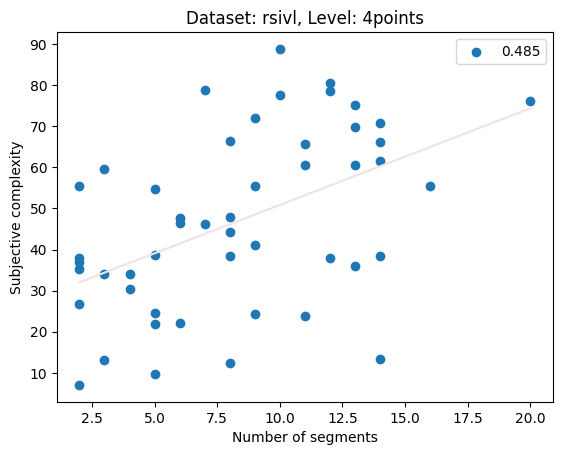

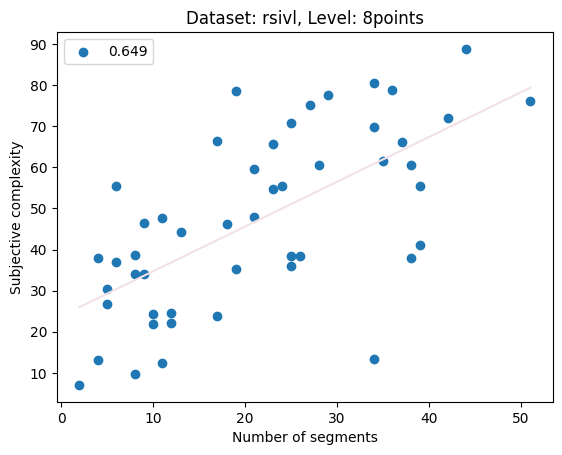

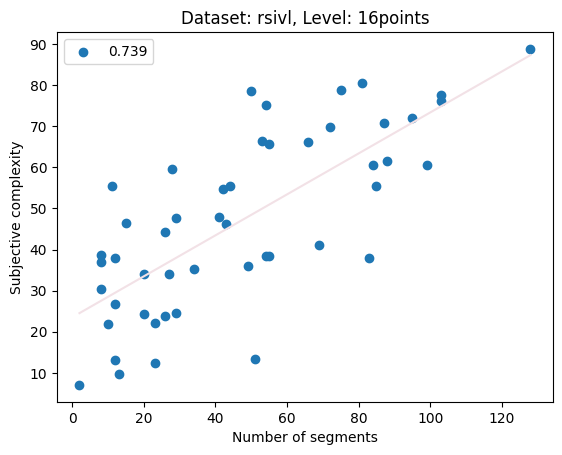

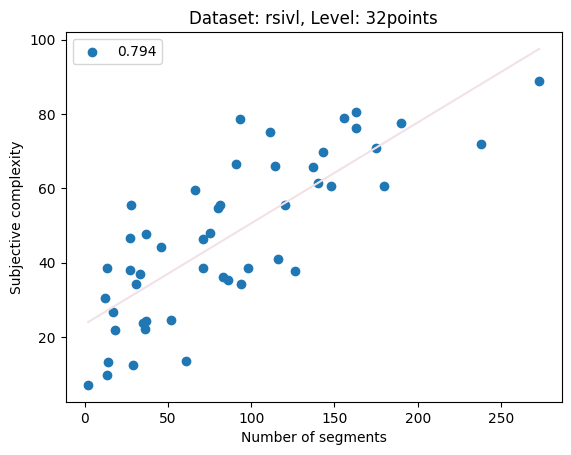

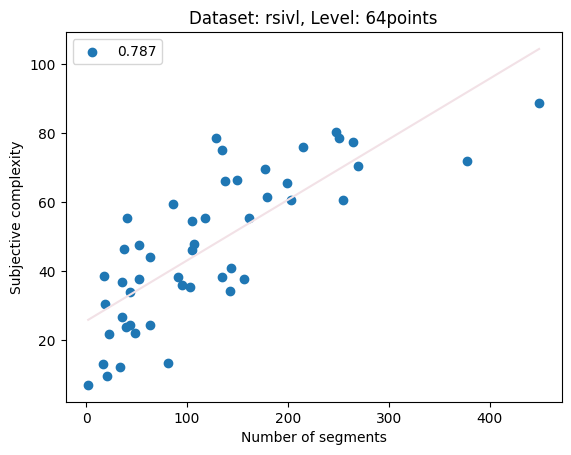

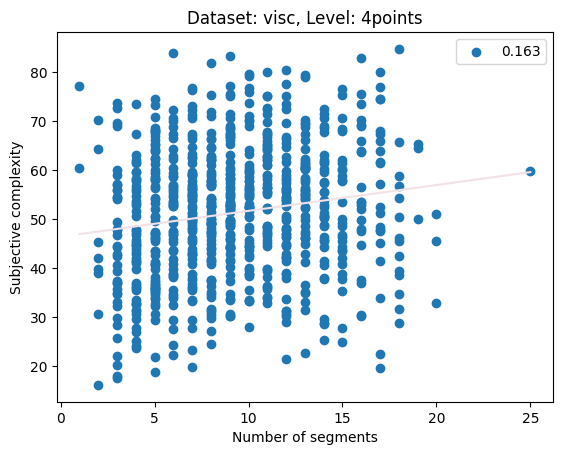

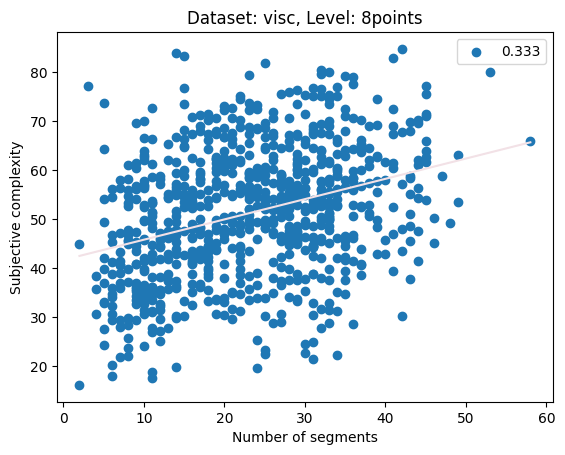

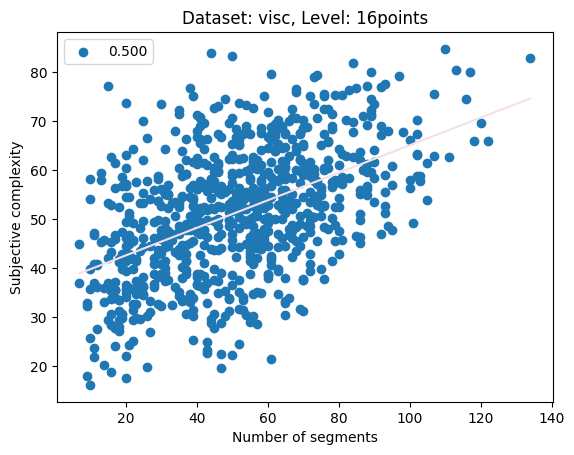

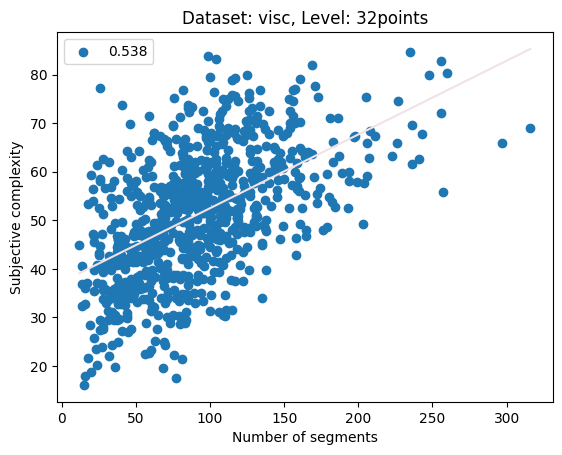

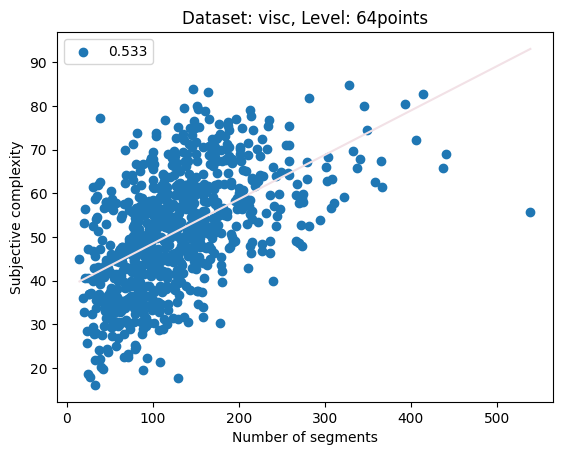

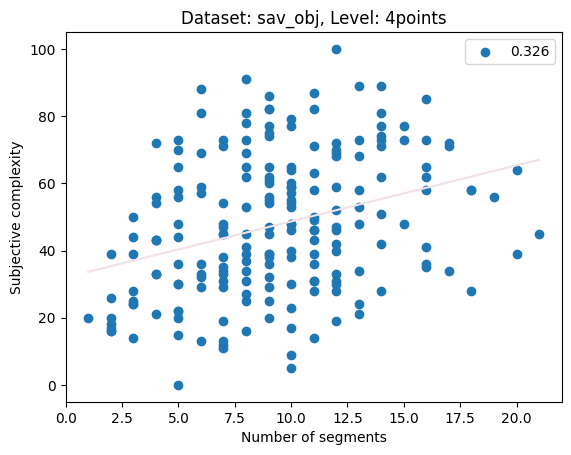

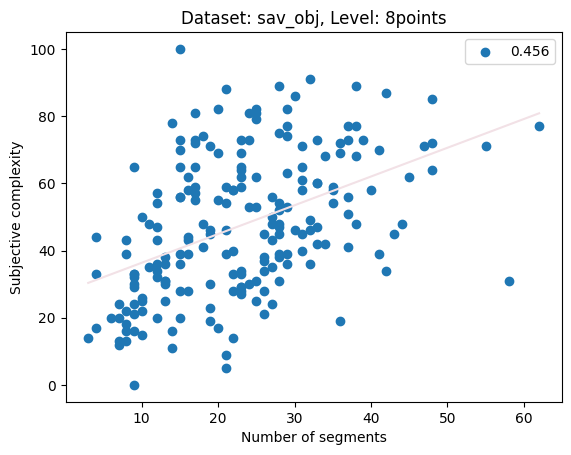

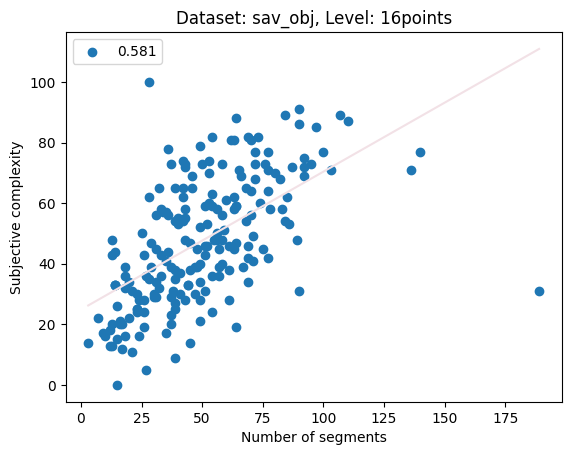

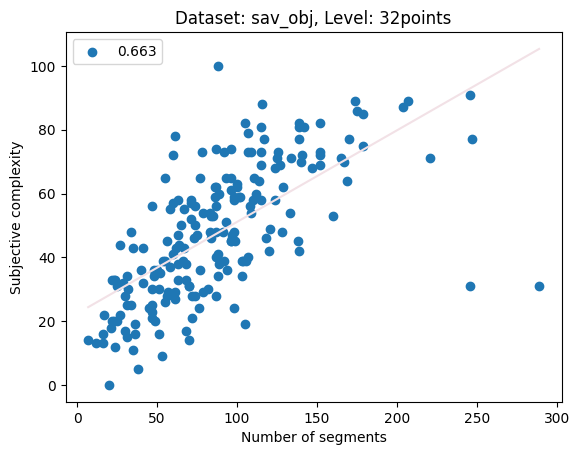

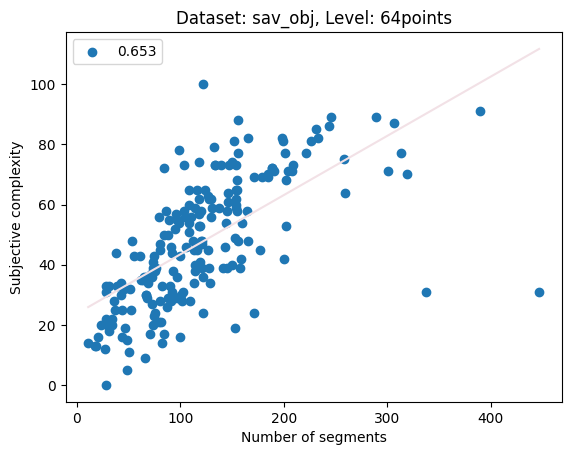

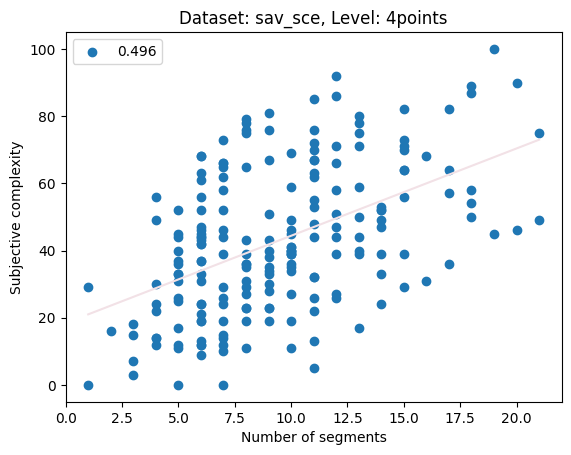

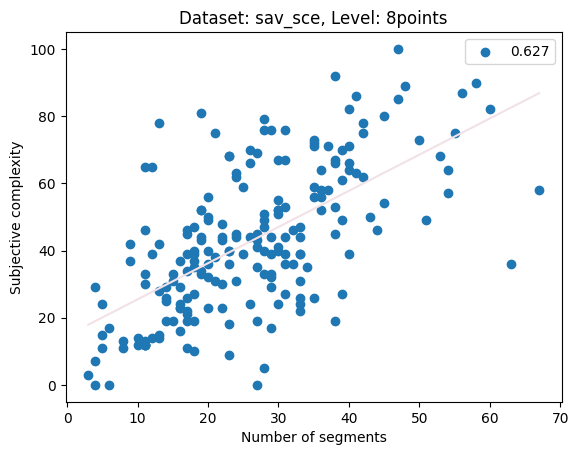

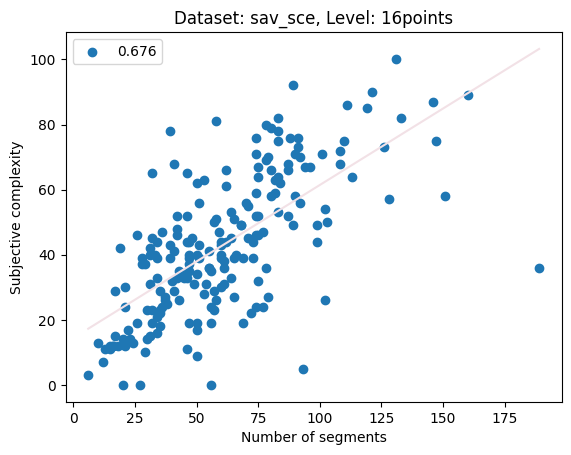

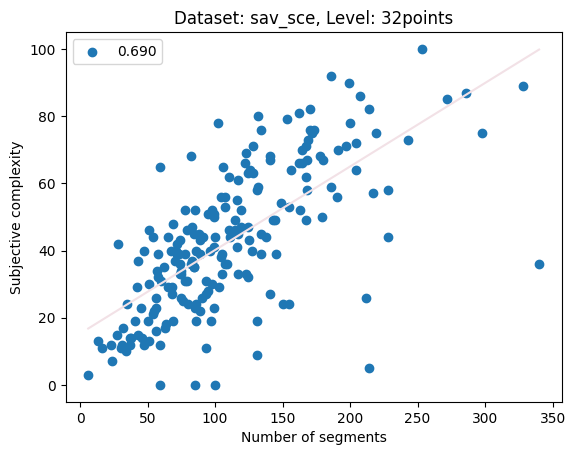

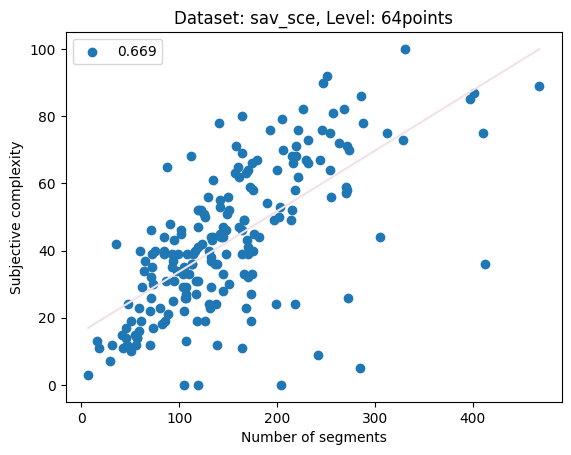

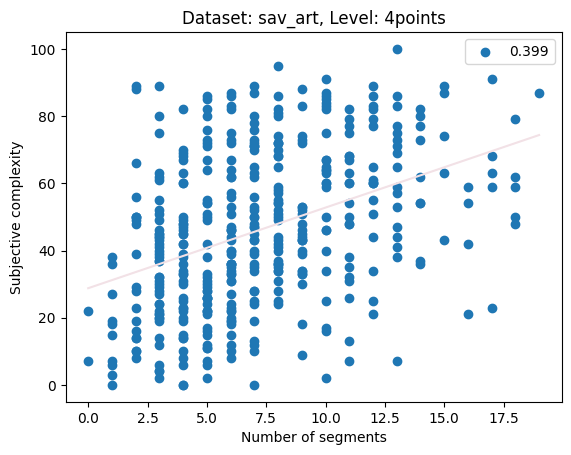

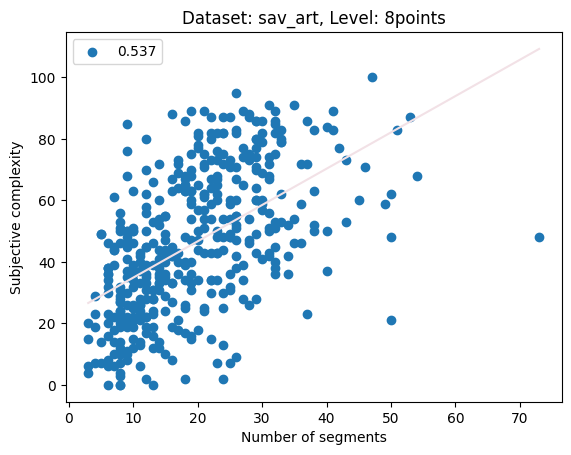

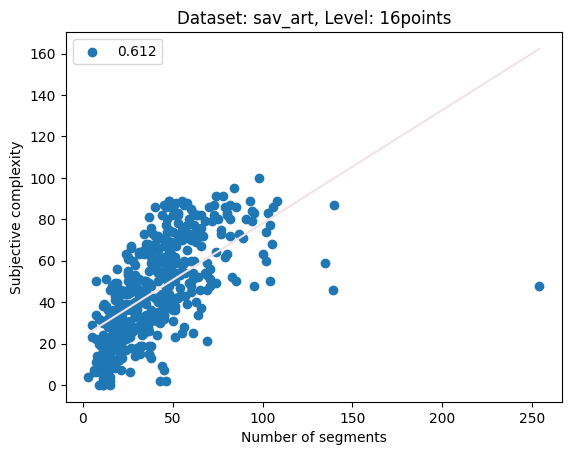

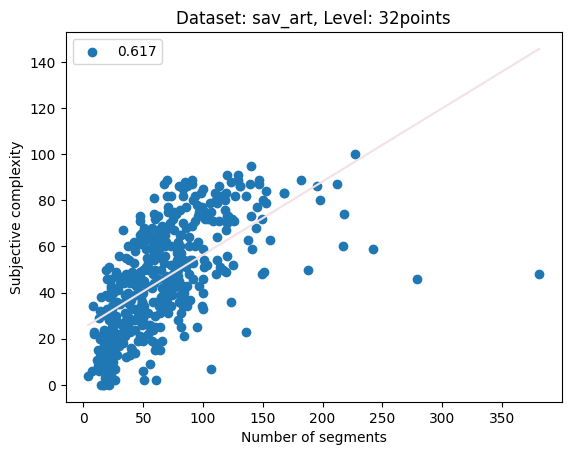

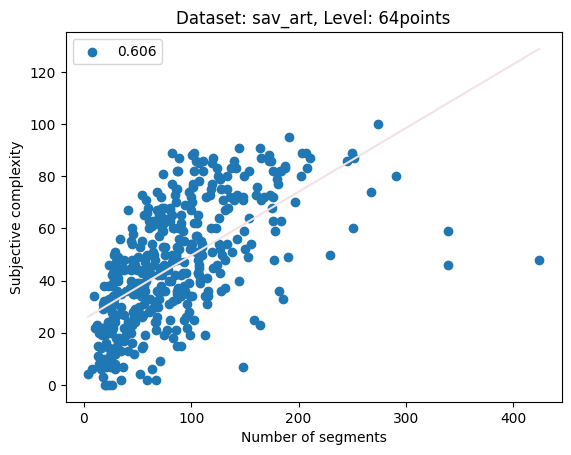

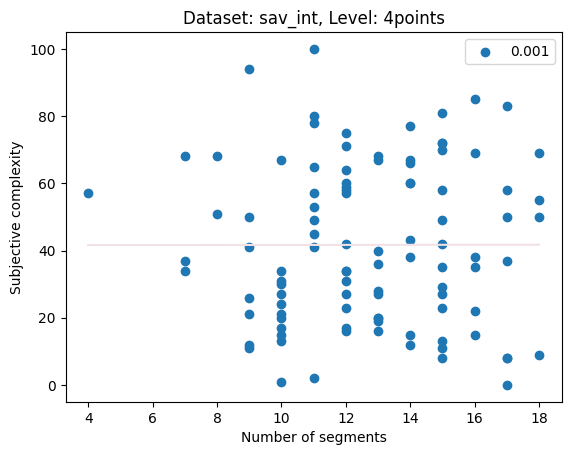

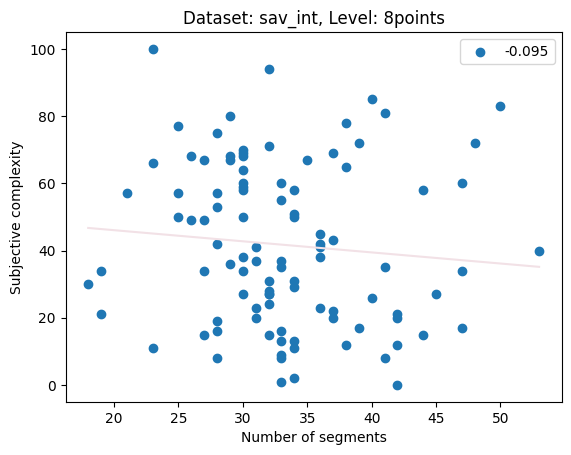

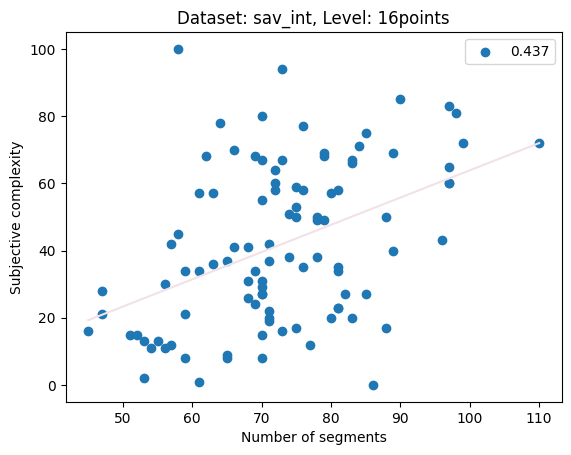

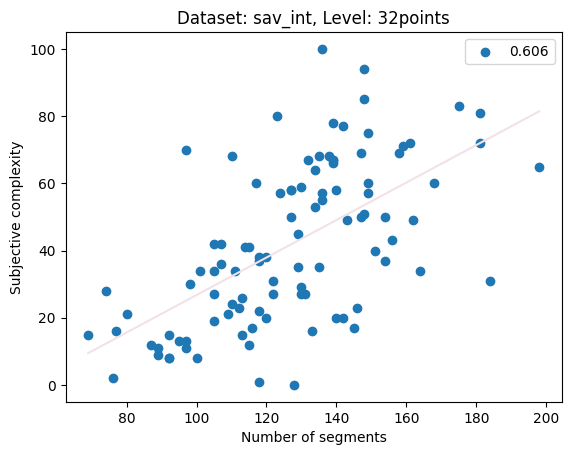

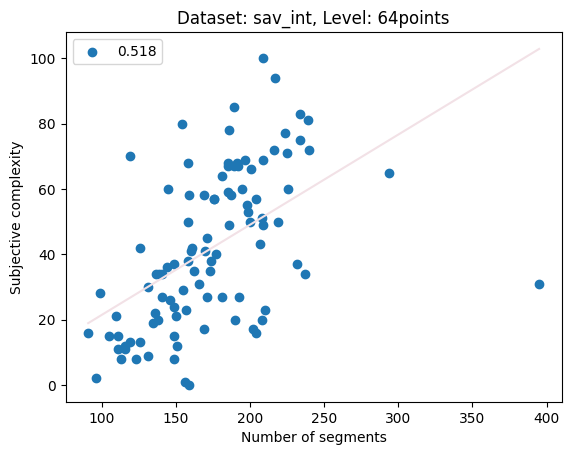

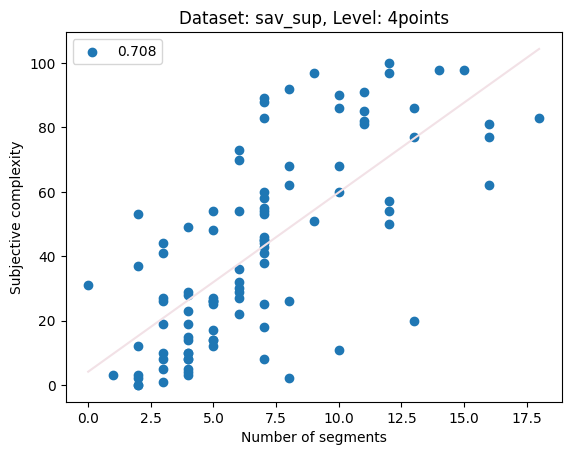

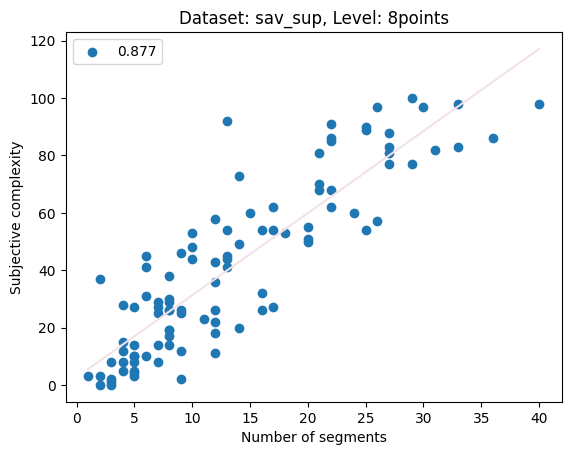

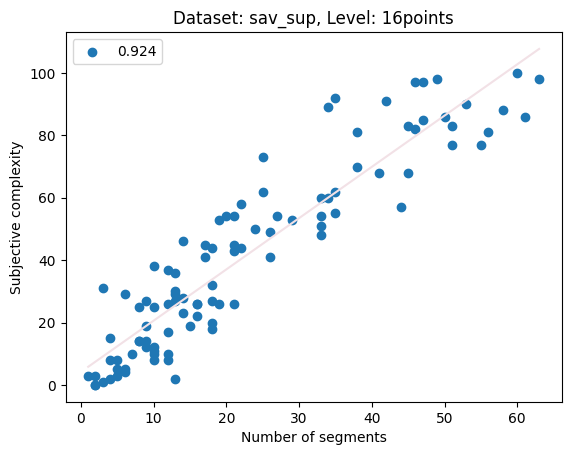

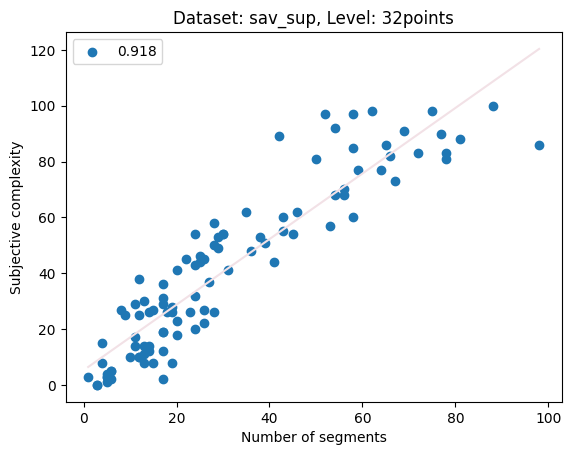

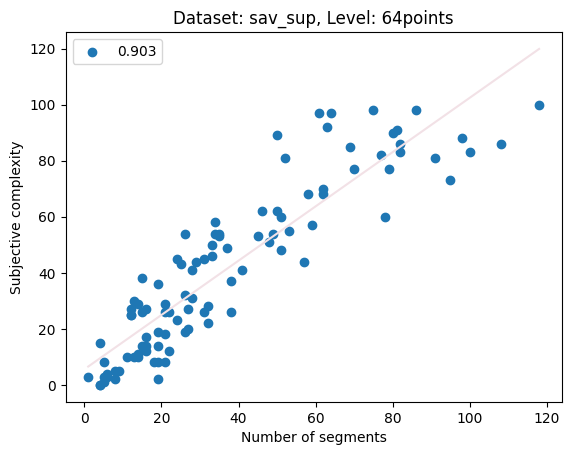

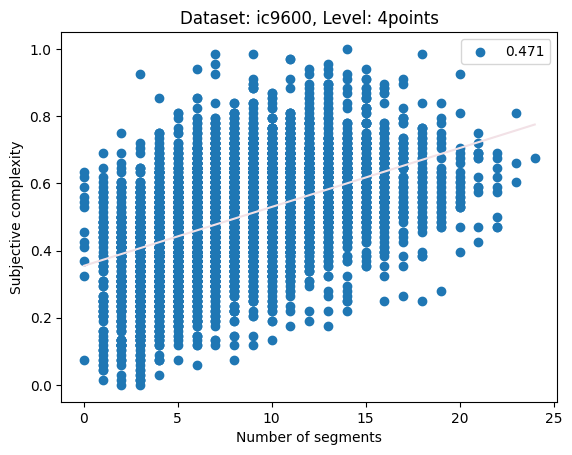

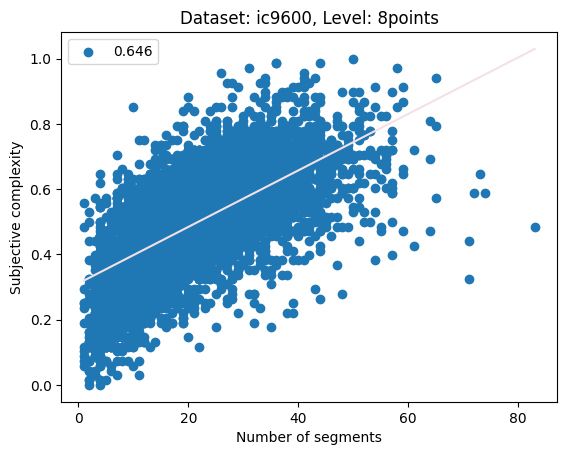

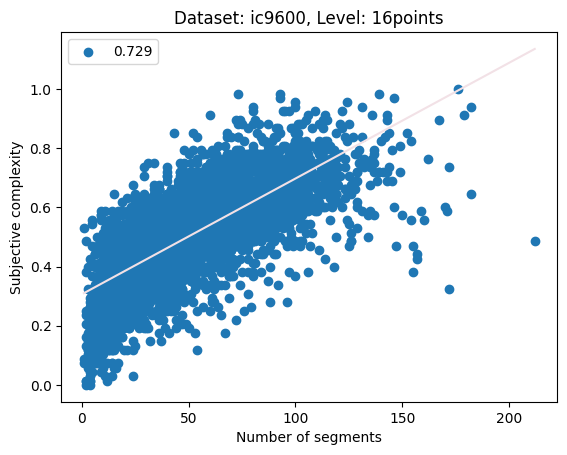

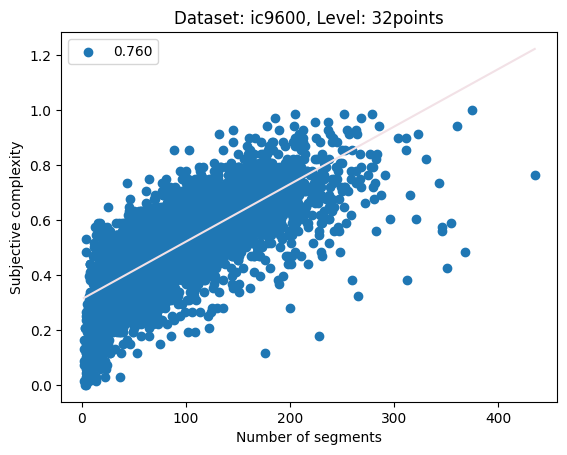

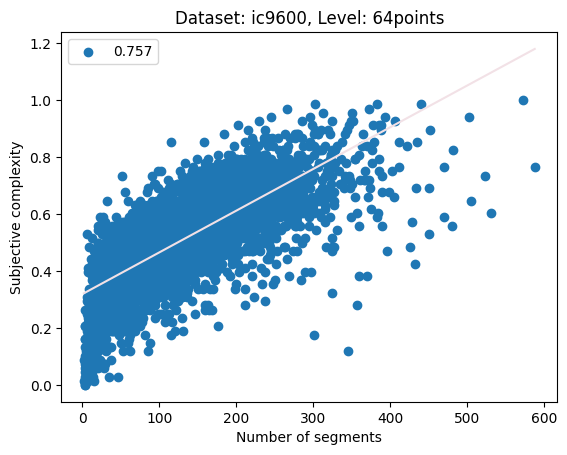

In [193]:
scatter_column_against_others(data, levels, correlations)

In [23]:
plt.close()

/tmp/ipykernel_22293/3546491335.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


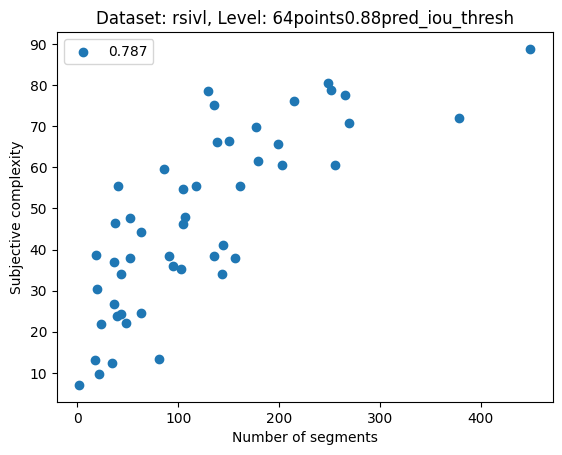

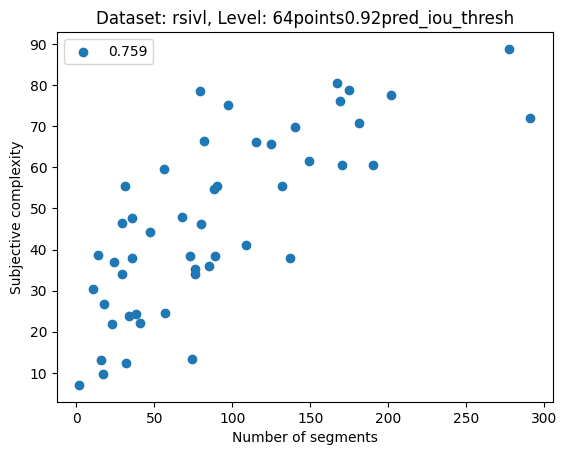

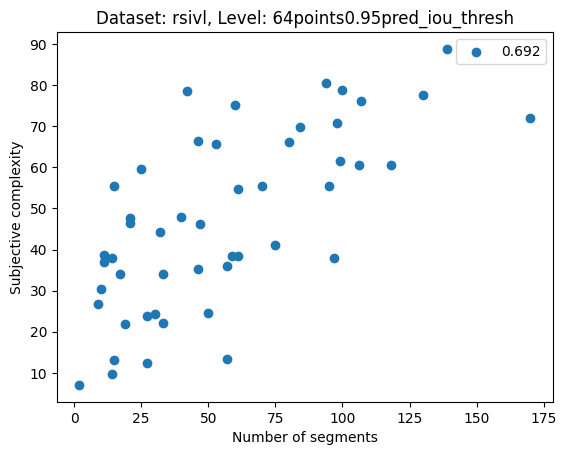

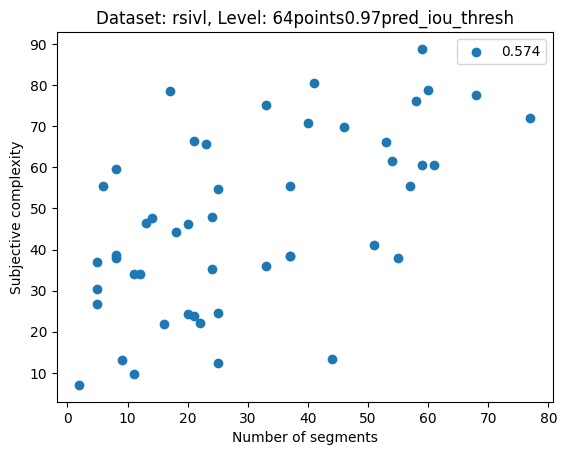

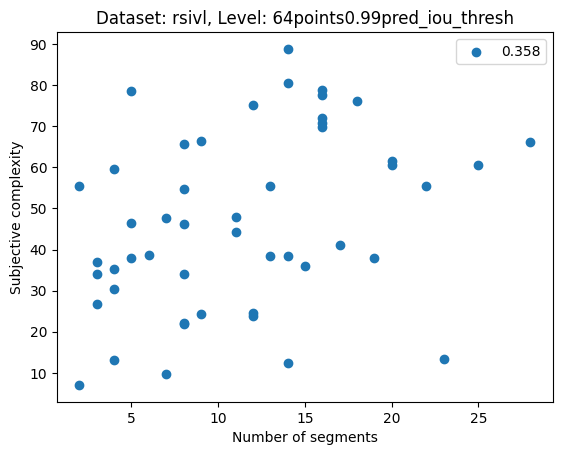

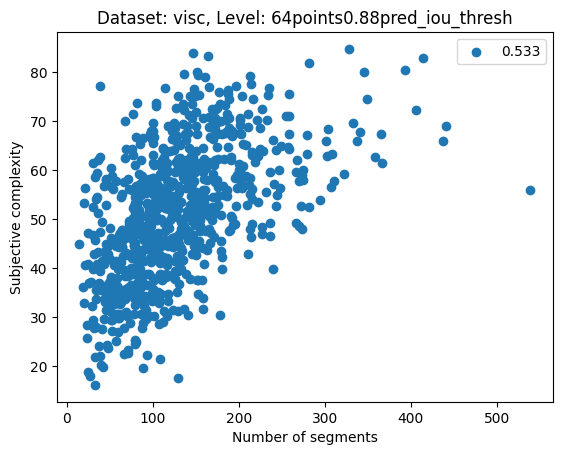

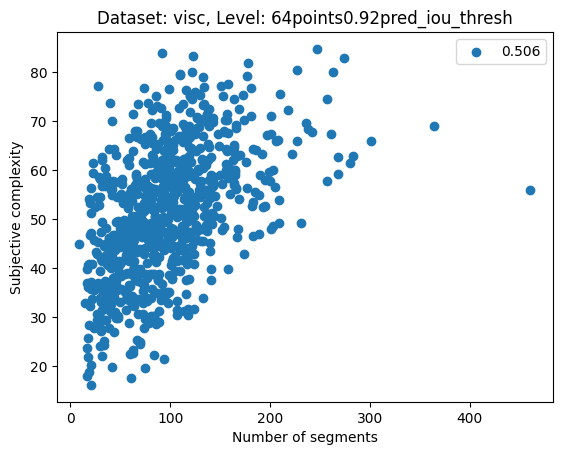

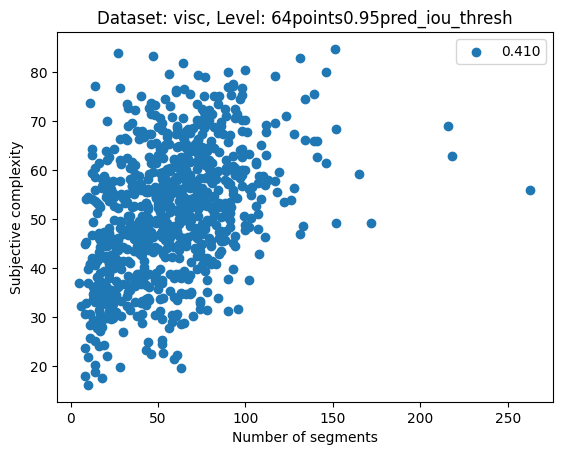

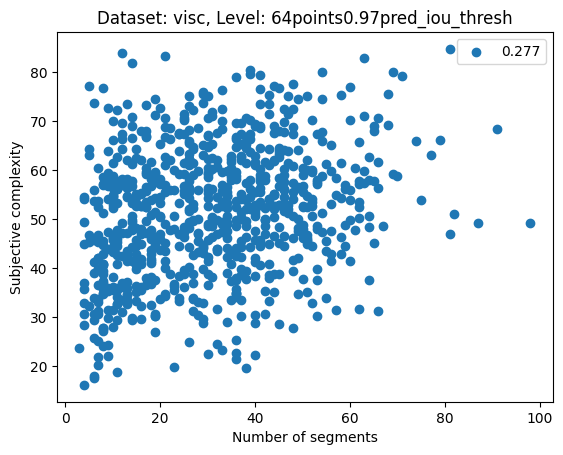

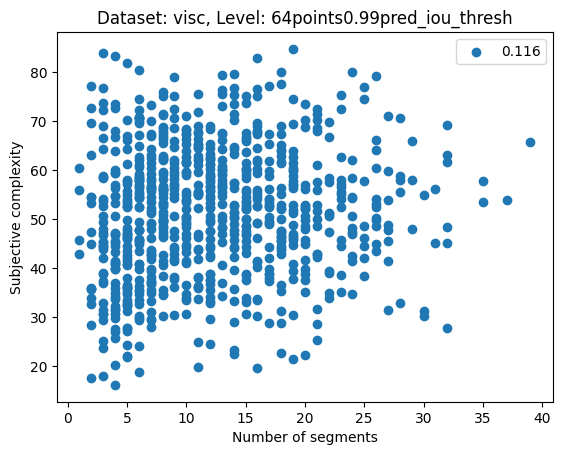

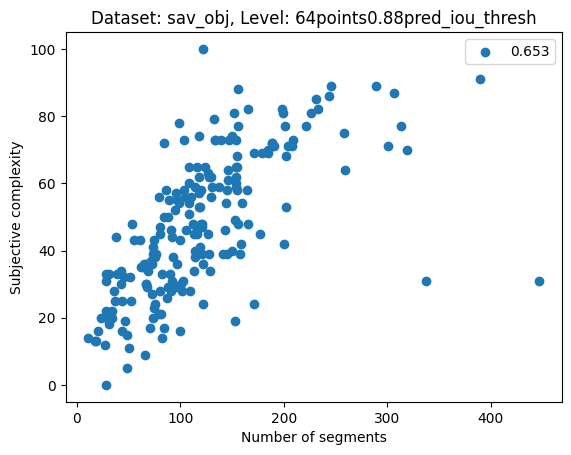

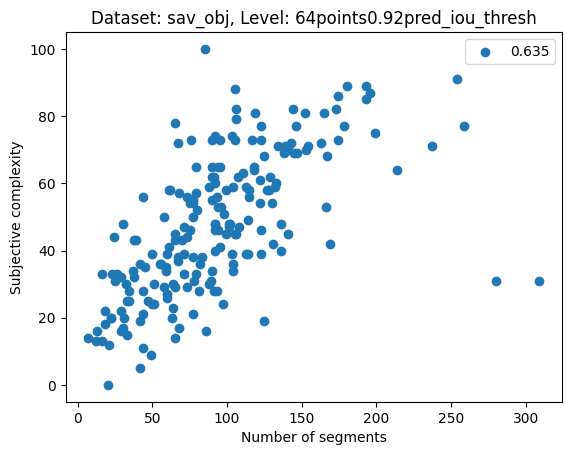

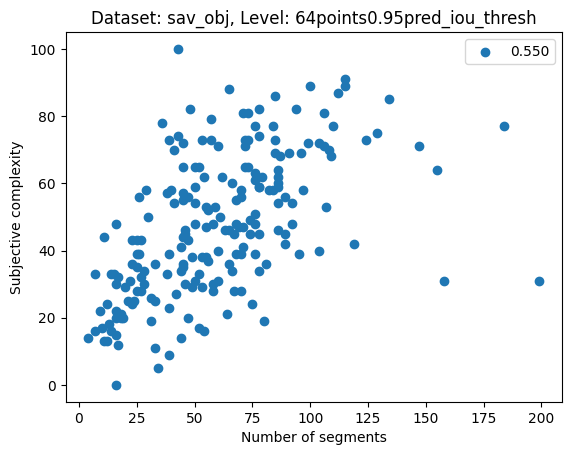

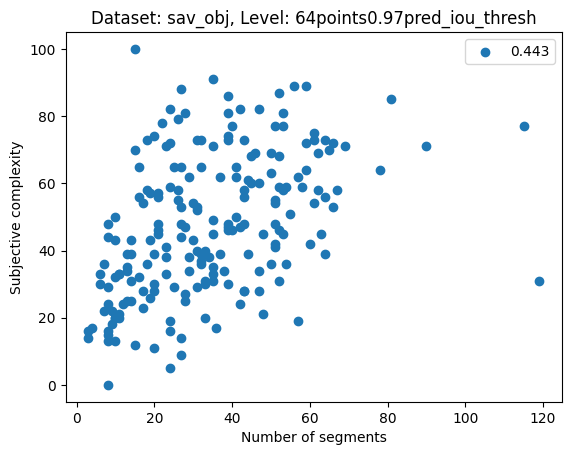

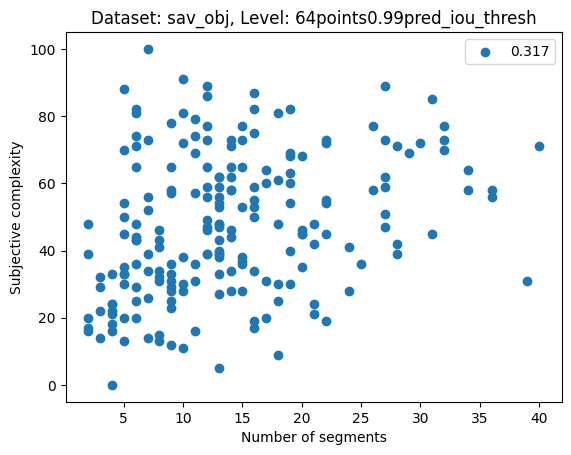

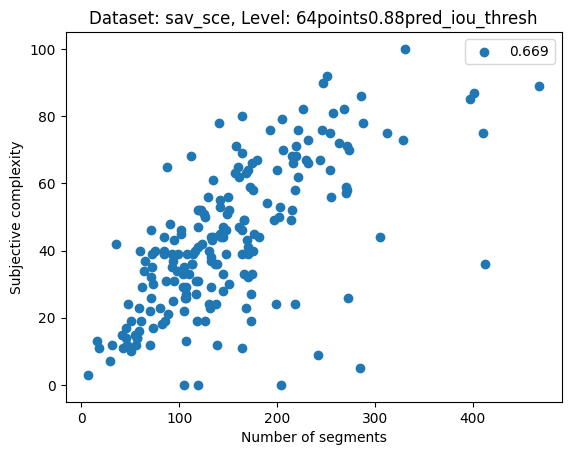

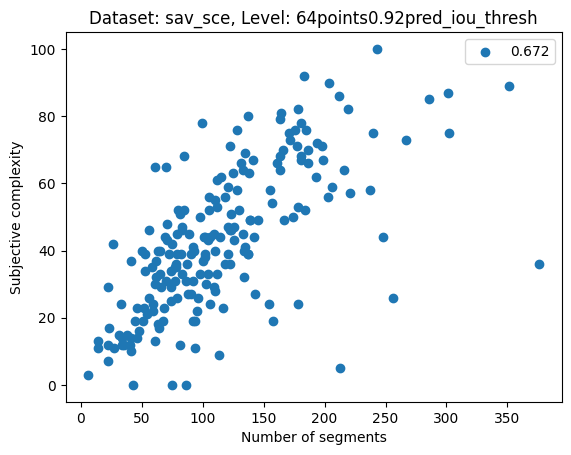

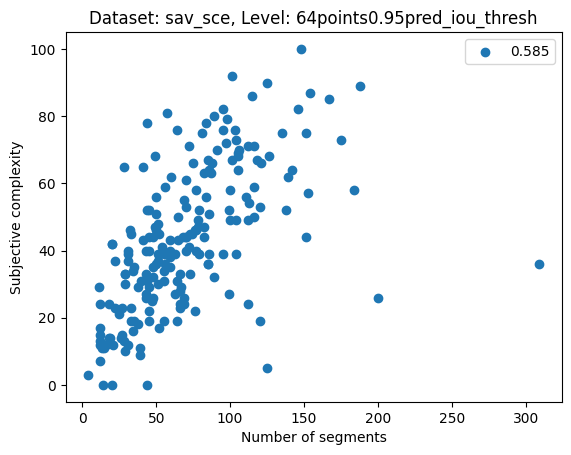

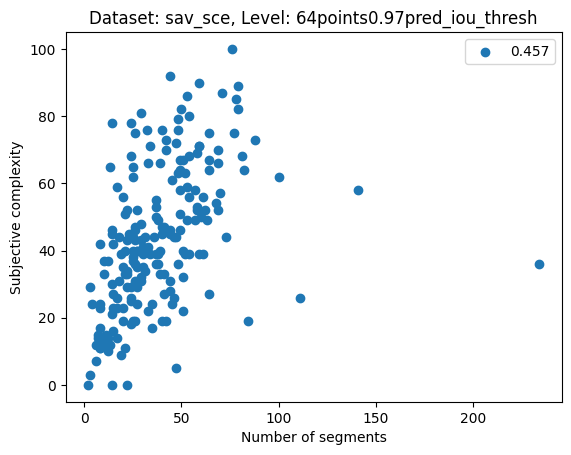

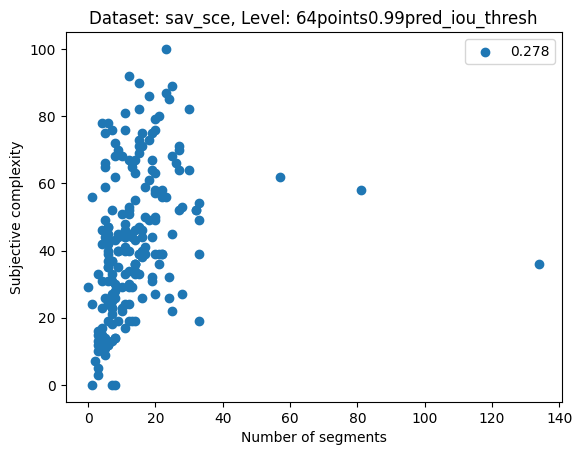

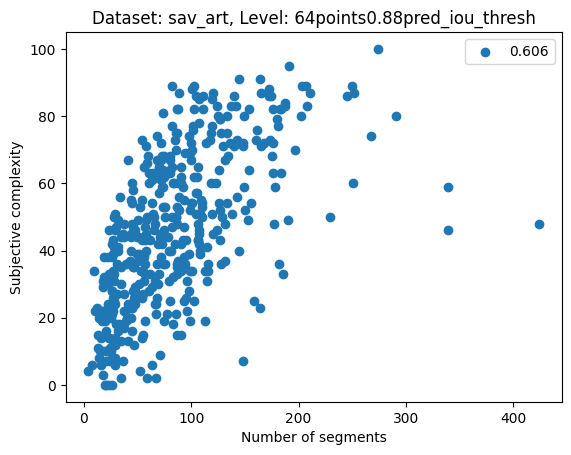

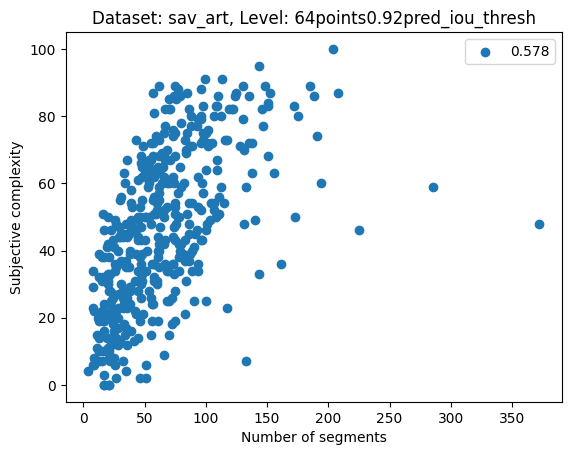

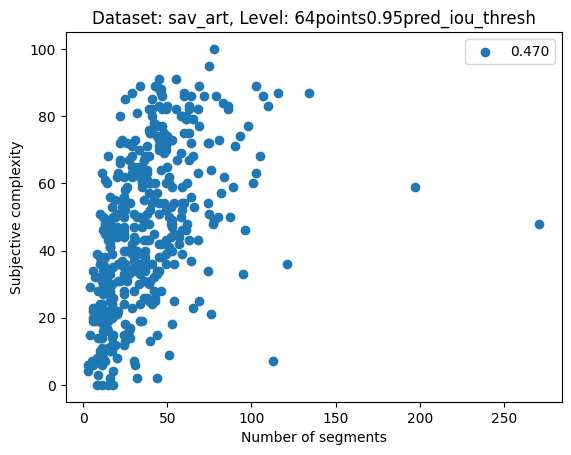

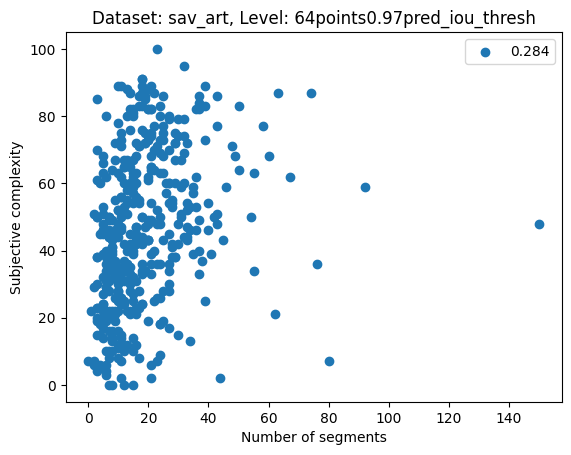

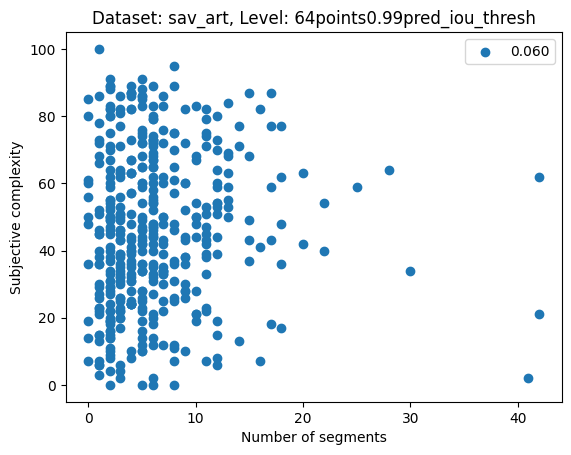

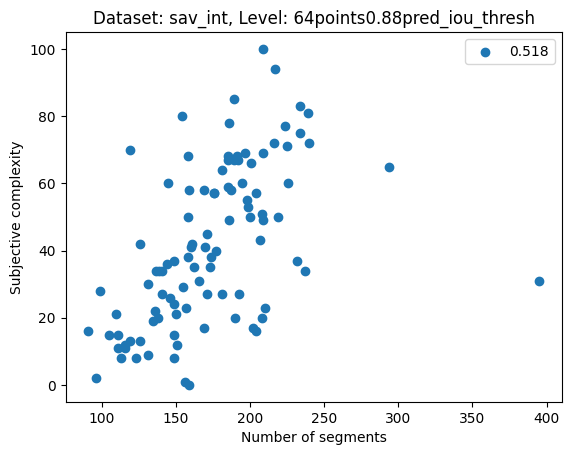

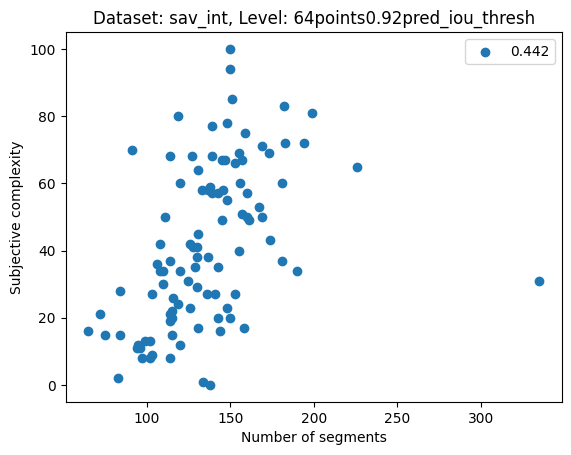

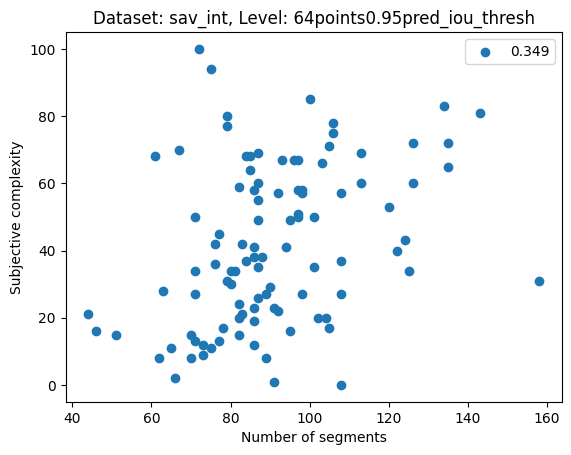

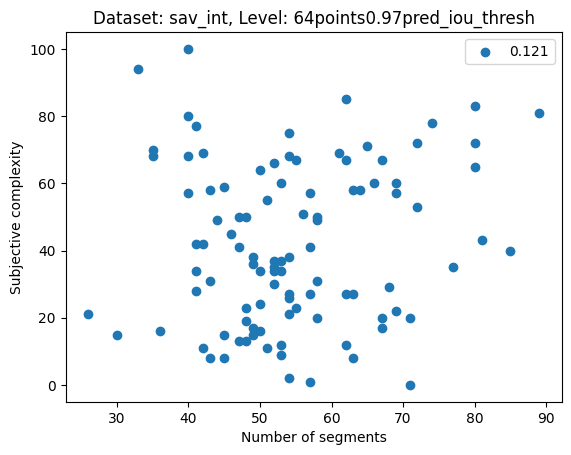

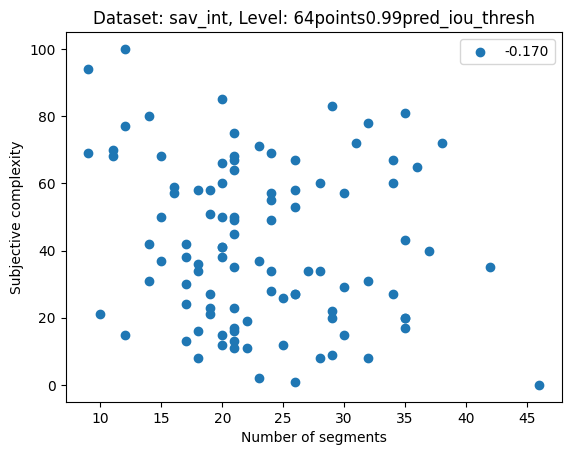

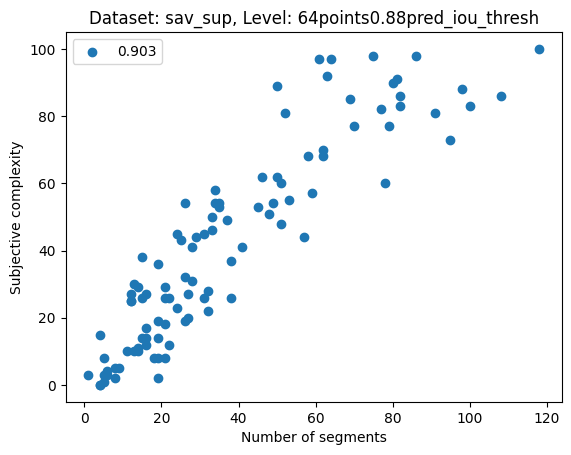

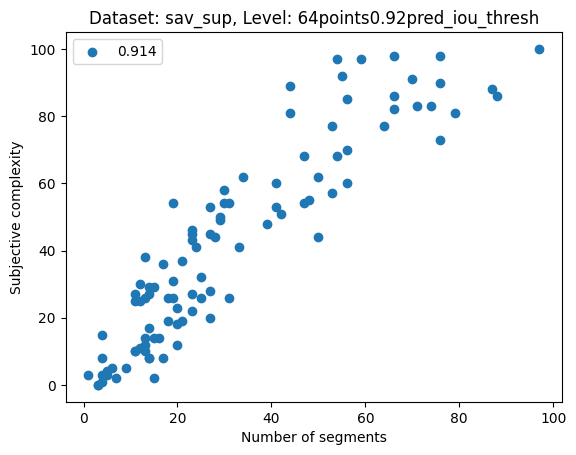

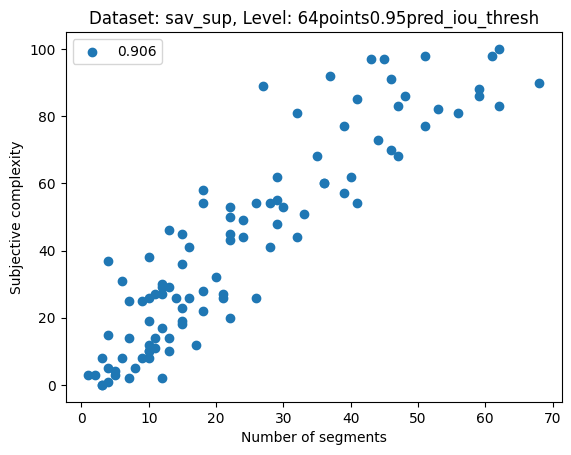

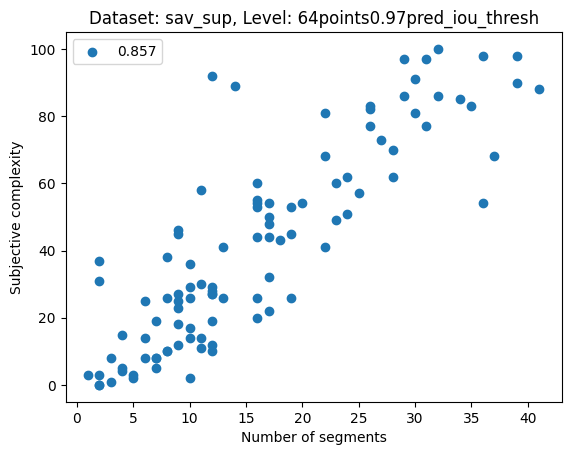

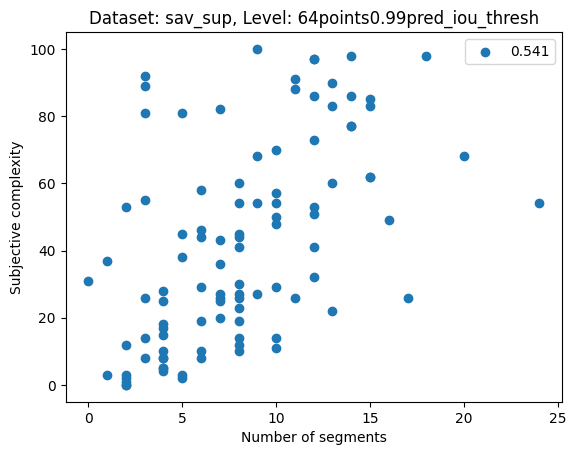

In [24]:
scatter_column_against_others(data2, levels2, correlations2)

In [25]:
plt.close()

# Find Outliers

In [83]:
for dataset in data.keys():
    for level in levels:
        x = data[dataset][level]
        y = data[dataset]["complexity"]
        f = np.poly1d(np.polyfit(x, y, 1))

        df = data[dataset]
        df['pred_{}'.format(level)] = f(x)
        df['diff_{}'.format(level)] = df['complexity'] - df['pred_{}'.format(level)]

In [88]:
diff_corrs = get_correlations(data, ["diff_{}".format(l) for l in levels])

In [90]:
diff_corrs['sav_art']

{'complexity': {'diff_4points': PearsonRResult(statistic=0.9170052325626168, pvalue=6.003343005955139e-169),
  'diff_8points': PearsonRResult(statistic=0.8436292763822292, pvalue=5.872086398187421e-115),
  'diff_16points': PearsonRResult(statistic=0.7906893646338778, pvalue=4.1598966810595473e-91),
  'diff_32points': PearsonRResult(statistic=0.786895820769915, pvalue=1.1455185240668799e-89),
  'diff_64points': PearsonRResult(statistic=0.7955856107026196, pvalue=5.19734961280913e-93)},
 'diff_4points': {'diff_8points': PearsonRResult(statistic=0.9265196592099783, pvalue=1.48419184286968e-179),
  'diff_16points': PearsonRResult(statistic=0.854284331852679, pvalue=7.599186341204887e-121),
  'diff_32points': PearsonRResult(statistic=0.8170334507331884, pvalue=5.258652033691943e-102),
  'diff_64points': PearsonRResult(statistic=0.8008720565566884, pvalue=3.9948638052532656e-95)},
 'diff_8points': {'diff_16points': PearsonRResult(statistic=0.9365489532287854, pvalue=2.080063494127546e-192),


In [96]:
outliers = {}
N = 10

for dataset in data.keys():
    outliers[dataset] = {}
    for level in levels:
        outliers[dataset][level] = {}


        outliers[dataset][level]['overestimated'] = data[dataset].sort_values(['diff_{}'.format(level)], ascending=True)[:N]
        outliers[dataset][level]['underestimated'] = data[dataset].sort_values(['diff_{}'.format(level)], ascending=False)[:N]
        outliers[dataset][level]['accurate'] = data[dataset].sort_values(by=['diff_{}'.format(level)], key=abs, ascending=True)[:N]

In [149]:
pd.set_option('display.precision', 2)
outliers['sav_obj']['32points']['accurate']

filename  4points  8points  16points  32points  64points  complexity  \
153   38.jpg       11       35        78       124       145          58   
48    66.jpg        5       12        27        48        73          36   
160   33.jpg        5       15        53       167       319          70   
32    10.jpg        4       28        68       109       144          54   
148    3.jpg       11       19        52        84       116          46   
198  119.jpg        7       18        43        91       156          48   
49    65.jpg       10       38        58        87       121          48   
133   40.jpg        9       15        33        50        67          36   
104   86.jpg        2        8        18        55        74          39   
190   23.jpg        9       21        37        54        77          39   

     pred_4points  diff_4points  pred_8points  diff_8points  pred_16points  \
153         50.33          7.67         57.74          0.26          60.37   
48          40.33         -4.33         38.06         -2.06          37.15   
160         40.33         29.67         40.63         29.37          48.99   
32          38.66         15.34         51.75          2.25          55.82   
148         50.33         -4.33         44.05          1.95          48.54   
198         43.66          4.34         43.20          4.80          44.44   
49          48.67         -0.67         60.31        -12.31          51.27   
133         47.00        -11.00         40.63         -4.63          39.89   
104         35.32          3.68         34.64          4.36          33.06   
190         47.00         -8.00         45.76         -6.76          41.71   

     diff_16points  pred_32points  diff_32points  pred_64points  diff_64points  
153          -2.37          57.97           0.03          52.28           5.72  
48           -1.15          36.15          -0.15          38.10          -2.10  
160          21.01          70.31          -0.31          86.55         -16.55  
32           -1.82          53.66           0.34          52.09           1.91  
148          -2.54          46.49          -0.49          46.57          -0.57  
198           3.56          48.49          -0.49          54.45          -6.45  
49           -3.27          47.35           0.65          47.56           0.44  
133          -3.89          36.72          -0.72          36.92          -0.92  
104           5.94          38.16           0.84          38.30           0.70  
190          -2.71          37.87           1.13          38.89           0.11